In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm


from sklearn.neighbors import KernelDensity 
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate


import xgboost
from xgboost import XGBRegressor, XGBClassifier

from tqdm import tqdm

In [2]:
import matplotlib as mpl
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 

# Reading the data

In [3]:
Wgamma_fidcross  = 584.6234734948906
Wjets_fidcross   = 600.5788869631236
ttgamma_fidcross = 28.773979008
B_fidcross_tot   = Wgamma_fidcross + Wjets_fidcross + ttgamma_fidcross
B_fidcross_tot

1213.9763394660142

In [4]:
Wgamma_expected = 58462.347349489064
Wjets_expected = 60057.888696312366
ttgamma_expected = 2877.3979008
B_expected = (ttgamma_expected + Wjets_expected + Wgamma_expected)

In [5]:
sample = 250_000 # Number of signal and background events to train and validate

Wgamma_sample  = int(round(sample * Wgamma_fidcross / B_fidcross_tot))
Wjets_sample   = int(round(sample * Wjets_fidcross / B_fidcross_tot))
ttgamma_sample = int(round(sample * ttgamma_fidcross / B_fidcross_tot))

print(Wgamma_sample)
print(Wjets_sample)
print(ttgamma_sample)

120394
123680
5926


In [6]:
##############
# input data #
##############

# photon -> (pT, eta, phi) from the leading photon
# jet -> (pT, eta, phi) from the leading jet
# lepton -> (pT, eta, phi) from the lepton (electron or muon)
# MET -> (pT, eta, phi) eta = 0 by construction, but phi is important because we have a lot of jets that we do not use
# hadinfo -> (HT, num_jets)  HT: sum PT of all the jets, number of jets (b-tag or not)


######
# SM #
######

# W gamma + W gamma jet #
# Dominant # Np es el W jet el dominant??

datFolderWgamma = '../data/Wgamma/'

photon_Wgamma  = np.loadtxt(datFolderWgamma + 'photon_3.dat', delimiter=' ')
jet_Wgamma     = np.loadtxt(datFolderWgamma + 'jet_3.dat', delimiter=' ')
lepton_Wgamma  = np.loadtxt(datFolderWgamma + 'lepton_3.dat', delimiter=' ')
MET_Wgamma     = np.loadtxt(datFolderWgamma + 'MET_3.dat', delimiter=' ')
hadinfo_Wgamma = np.loadtxt(datFolderWgamma + 'hadinfo_3.dat', delimiter=' ')


# W jet + W jet jet #

datFolderWjets = '../data/Wjets/'

photon_Wjets  = np.loadtxt(datFolderWjets + 'photon_3.dat', delimiter=' ')
jet_Wjets     = np.loadtxt(datFolderWjets + 'jet_3.dat', delimiter=' ')
lepton_Wjets  = np.loadtxt(datFolderWjets + 'lepton_3.dat', delimiter=' ')
MET_Wjets     = np.loadtxt(datFolderWjets + 'MET_3.dat', delimiter=' ')
hadinfo_Wjets = np.loadtxt(datFolderWjets + 'hadinfo_3.dat', delimiter=' ')


# tt gamma + tt gamma jet #

datFolderttgamma = '../data/ttGamma/'
 
photon_ttgamma  = np.loadtxt(datFolderttgamma + 'photon_3.dat', delimiter=' ')
jet_ttgamma     = np.loadtxt(datFolderttgamma + 'jet_3.dat', delimiter=' ')
lepton_ttgamma  = np.loadtxt(datFolderttgamma + 'lepton_3.dat', delimiter=' ')
MET_ttgamma     = np.loadtxt(datFolderttgamma + 'MET_3.dat', delimiter=' ')
hadinfo_ttgamma = np.loadtxt(datFolderttgamma + 'hadinfo_3.dat', delimiter=' ')


photon_SM  = np.concatenate([photon_Wgamma[:Wgamma_sample], photon_Wjets[:Wjets_sample], photon_ttgamma[:ttgamma_sample]])
jet_SM     = np.concatenate([jet_Wgamma[:Wgamma_sample], jet_Wjets[:Wjets_sample], jet_ttgamma[:ttgamma_sample]]) 
lepton_SM  = np.concatenate([lepton_Wgamma[:Wgamma_sample], lepton_Wjets[:Wjets_sample], lepton_ttgamma[:ttgamma_sample]])
MET_SM     = np.concatenate([MET_Wgamma[:Wgamma_sample], MET_Wjets[:Wjets_sample], MET_ttgamma[:ttgamma_sample]])
hadinfo_SM = np.concatenate([hadinfo_Wgamma[:Wgamma_sample], hadinfo_Wjets[:Wjets_sample], hadinfo_ttgamma[:ttgamma_sample]])

photon_SM_pool  = np.concatenate([photon_Wgamma[Wgamma_sample:], photon_Wjets[Wjets_sample:], photon_ttgamma[ttgamma_sample:]])
jet_SM_pool     = np.concatenate([jet_Wgamma[Wgamma_sample:], jet_Wjets[Wjets_sample:], jet_ttgamma[ttgamma_sample:]]) 
lepton_SM_pool  = np.concatenate([lepton_Wgamma[Wgamma_sample:], lepton_Wjets[Wjets_sample:], lepton_ttgamma[ttgamma_sample:]])
MET_SM_pool     = np.concatenate([MET_Wgamma[Wgamma_sample:], MET_Wjets[Wjets_sample:], MET_ttgamma[ttgamma_sample:]])
hadinfo_SM_pool = np.concatenate([hadinfo_Wgamma[Wgamma_sample:], hadinfo_Wjets[Wjets_sample:], hadinfo_ttgamma[ttgamma_sample:]])

In [7]:
bkg_flag = np.zeros(len(photon_SM))

bkg_flag[:Wgamma_sample] = 1
bkg_flag[Wgamma_sample:(Wgamma_sample + Wjets_sample)] = 2
bkg_flag[(Wgamma_sample + Wjets_sample):len(photon_SM)] = 3

In [8]:
print(photon_Wjets.shape)
print(photon_ttgamma.shape)
print(photon_Wgamma.shape)

(259345, 4)
(2052938, 4)
(3579946, 4)


In [9]:
######
# NP #
######

datFolderNP = '../data/Signal/'

photon_NP  = []
jet_NP     = []
lepton_NP  = []
MET_NP     = []
hadinfo_NP = []
name       = []
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
    name.append('BP' + str(i))
    photon_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_photon_3.dat', delimiter=' ') )
    jet_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_jet_3.dat', delimiter=' ') )
    lepton_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_lepton_3.dat', delimiter=' ') )
    MET_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_MET_3.dat', delimiter=' ') )
    hadinfo_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_hadinfo_3.dat', delimiter=' ') )

In [10]:
print('SM', lepton_SM.shape)
for i in range(len(jet_NP)):
    print(name[i], lepton_NP[i].shape)

SM (250000, 4)
BP1 (238160, 4)
BP2 (246196, 4)
BP3 (242249, 4)
BP4 (301575, 4)
BP5 (266047, 4)
BP6 (203155, 4)
BP7 (315960, 4)
BP8 (280065, 4)
BP9 (225958, 4)
BP10 (326687, 4)
BP11 (292051, 4)
BP12 (244271, 4)
BP13 (334782, 4)
BP14 (301215, 4)
BP15 (258277, 4)


In [11]:
cross_section_bps    = np.asarray([190, 189, 189, 92, 92, 92, 49, 48, 48, 27, 27, 27, 16, 16, 16])
branching_ratios_bps = np.asarray([0.14, 0.37, 0.73, 0.15, 0.36, 0.67, 0.16, 0.36, 0.62, 0.17, 0.35, 0.58, 0.16, 0.32, 0.52])

signal_cross        = cross_section_bps * branching_ratios_bps *  0.2134 # fb
signal_init_sim_eve = np.asarray([836673,1e6,1.4e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6])
signal_cut_ev       = np.asarray([238160,246196,24249,301575,266047,203155,315960,280065,225958,326687,292051,244271,334782,301215,258277])
signal_NLO          = 1.25

cross       = signal_cross * signal_NLO
aceptancia  = signal_cut_ev / (1. * signal_init_sim_eve)
luminosidad = 100

signal_fidcross = cross * aceptancia
S_expected = cross * aceptancia * luminosidad

print('fiducial cross section: ', signal_fidcross)
print('Events expected: ', S_expected)

fiducial cross section:  [2.01975705 4.59249772 0.63746286 1.11014281 2.35046139 3.34036999
 0.66077347 1.29094281 1.79376306 0.39998985 0.73619851 1.02039447
 0.22861593 0.4113874  0.57320964]
Events expected:  [201.97570473 459.24977152  63.74628649 111.01428112 235.04613937
 334.03699928  66.07734672 129.09428136 179.37630638  39.99898458
  73.61985102 102.03944697  22.86159322  41.13873984  57.32096427]


In [12]:
print(photon_SM.shape)
print(photon_NP[0].shape)

(250000, 4)
(238160, 4)


# Plots

In [19]:
cmap = cm.get_cmap('viridis', len(photon_NP))

In [20]:
BPs2plot = [2,5,8,11,14]

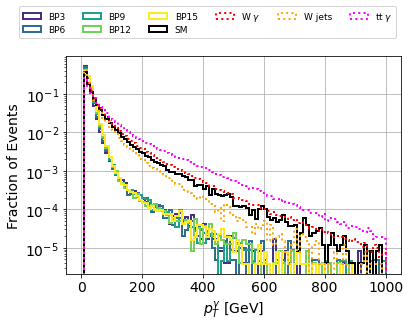

In [29]:
for i in BPs2plot:
    weights = np.ones_like(photon_NP[i][:,0])/len(photon_NP[i][:,0])
    plt.hist(photon_NP[i][:,0], weights=weights, bins=100, range=[0,1000], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(photon_SM[:,0])/len(photon_SM[:,0])
plt.hist(photon_SM[:,0], weights=weights, bins=100, range=[0,1000], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(photon_Wgamma[:,0])/len(photon_Wgamma[:,0])
plt.hist(photon_Wgamma[:,0], weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(photon_Wjets[:,0])/len(photon_Wjets[:,0])
plt.hist(photon_Wjets[:,0], weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(photon_ttgamma[:,0])/len(photon_ttgamma[:,0])
plt.hist(photon_ttgamma[:,0], weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()
plt.xlabel(r"$p_{T}^{\gamma}$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1., 1.25), ncol = 6)
#plt.savefig('../graph/pt_leadingPhoton_dist.png', bbox_inches='tight')

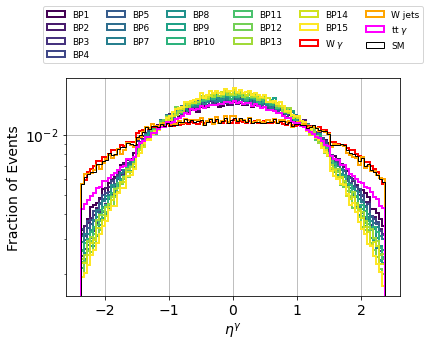

In [29]:
for i in range(len(photon_NP)):
    weights = np.ones_like(photon_NP[i][:,1])/len(photon_NP[i][:,1])
    plt.hist(photon_NP[i][:,1], weights=weights, bins=100, lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(photon_Wgamma[:,1])/len(photon_Wgamma[:,1])
plt.hist(photon_Wgamma[:,1], weights=weights, bins=100, lw=2,linestyle='solid', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(photon_Wjets[:,1])/len(photon_Wjets[:,1])
plt.hist(photon_Wjets[:,1], weights=weights, bins=100, lw=2,linestyle='solid', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(photon_ttgamma[:,1])/len(photon_ttgamma[:,1])
plt.hist(photon_ttgamma[:,1], weights=weights, bins=100, lw=2,linestyle='solid', edgecolor='magenta', histtype='step', label="tt $\gamma$")
weights = np.ones_like(photon_SM[:,1])/len(photon_SM[:,1])
plt.hist(photon_SM[:,1], weights=weights, bins=100, lw=1, edgecolor='black', histtype='step', label="SM", zorder=2)

plt.grid()  
plt.xlabel(r"$\eta^{\gamma}$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='lower center',fontsize=9,bbox_to_anchor=(0.5, 1.05), ncol = 6)
plt.savefig('../graph/pseudoRapidity_leadingPhoton_dist.png', bbox_inches='tight')

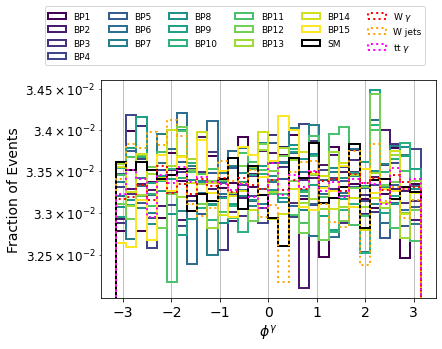

In [30]:
for i in range(len(photon_NP)):
    weights = np.ones_like(photon_NP[i][:,2])/len(photon_NP[i][:,2])
    plt.hist(photon_NP[i][:,2], weights=weights, bins=30, lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(photon_SM[:,2])/len(photon_SM[:,2])
plt.hist(photon_SM[:,2], weights=weights, bins=30, lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(photon_Wgamma[:,2])/len(photon_Wgamma[:,2])
plt.hist(photon_Wgamma[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(photon_Wjets[:,2])/len(photon_Wjets[:,2])
plt.hist(photon_Wjets[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(photon_ttgamma[:,2])/len(photon_ttgamma[:,2])
plt.hist(photon_ttgamma[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$\phi^{\gamma}$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='lower center',fontsize=9,bbox_to_anchor=(0.4, 1.05), ncol = 6)
plt.savefig('../graph/phi_leadingPhoton_dist.png', bbox_inches='tight')

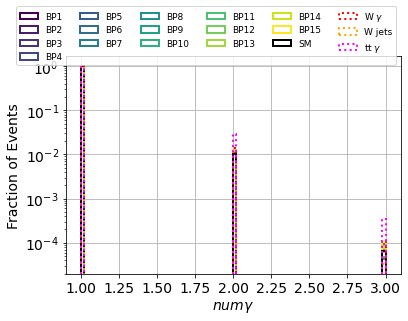

In [31]:
for i in range(len(photon_NP)):
    weights = np.ones_like(photon_NP[i][:,3])/len(photon_NP[i][:,3])
    plt.hist(photon_NP[i][:,3], weights=weights, bins=100, range=[1, np.max(photon_SM[:,3])], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(photon_SM[:,3])/len(photon_SM[:,3])
plt.hist(photon_SM[:,3], weights=weights, bins=100, range=[1, np.max(photon_SM[:,3])], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(photon_Wgamma[:,3])/len(photon_Wgamma[:,3])
plt.hist(photon_Wgamma[:,3], weights=weights, bins=100, range=[1, np.max(photon_SM[:,3])], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(photon_Wjets[:,3])/len(photon_Wjets[:,0])
plt.hist(photon_Wjets[:,3], weights=weights, bins=100, range=[1, np.max(photon_SM[:,3])], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(photon_ttgamma[:,3])/len(photon_ttgamma[:,0])
plt.hist(photon_ttgamma[:,3], weights=weights, bins=100, range=[1, np.max(photon_SM[:,3])], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()
plt.xlabel(r"$num \gamma$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1., 1.25), ncol = 6)
plt.savefig('../graph/num_Photons_dist.png', bbox_inches='tight')

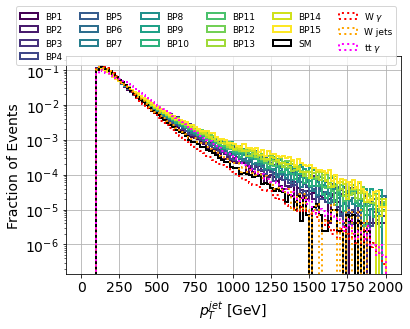

In [32]:
for i in range(len(photon_NP)):
    weights = np.ones_like(jet_NP[i][:,0])/len(jet_NP[i][:,0])
    plt.hist(jet_NP[i][:,0], weights=weights, bins=100, range=[0,2000], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(jet_SM[:,0])/len(jet_SM[:,0])
plt.hist(jet_SM[:,0], weights=weights, bins=100, range=[0,2000], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(jet_Wgamma[:,0])/len(jet_Wgamma[:,0])
plt.hist(jet_Wgamma[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(jet_Wjets[:,0])/len(jet_Wjets[:,0])
plt.hist(jet_Wjets[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(jet_ttgamma[:,0])/len(jet_ttgamma[:,0])
plt.hist(jet_ttgamma[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$p_T^{jet}$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1., 1.25), ncol = 6)
plt.savefig('../graph/pt_leadingJet_dist.png', bbox_inches='tight')

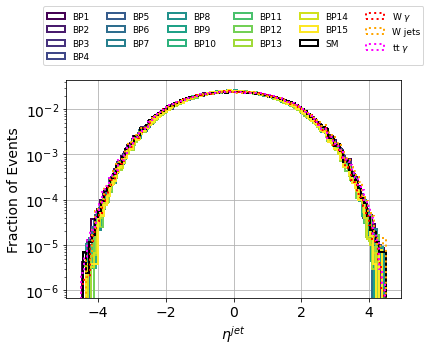

In [33]:
for i in range(len(photon_NP)):
    weights = np.ones_like(jet_NP[i][:,1])/len(jet_NP[i][:,1])
    plt.hist(jet_NP[i][:,1], weights=weights, bins=100, lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(jet_SM[:,1])/len(jet_SM[:,1])
plt.hist(jet_SM[:,1], weights=weights, bins=100, lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(jet_Wgamma[:,1])/len(jet_Wgamma[:,1])
plt.hist(jet_Wgamma[:,1], weights=weights, bins=100, lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(jet_Wjets[:,1])/len(jet_Wjets[:,1])
plt.hist(jet_Wjets[:,1], weights=weights, bins=100, lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(jet_ttgamma[:,1])/len(jet_ttgamma[:,1])
plt.hist(jet_ttgamma[:,1], weights=weights, bins=100, lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$\eta^{jet}$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='lower center',fontsize=9,bbox_to_anchor=(0.5, 1.05), ncol = 6)
plt.savefig('../graph/pseudoRapidity_leadingJet_dist.png', bbox_inches='tight')

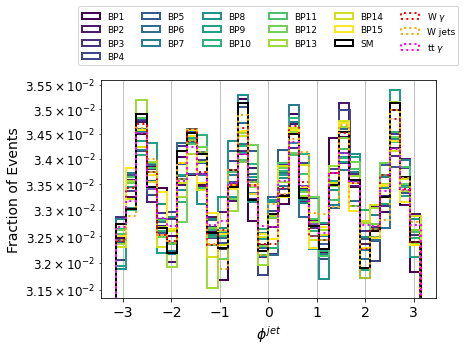

In [34]:
for i in range(len(photon_NP)):
    weights = np.ones_like(jet_NP[i][:,2])/len(jet_NP[i][:,2])
    plt.hist(jet_NP[i][:,2], weights=weights, bins=30, lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(jet_SM[:,2])/len(jet_SM[:,2])
plt.hist(jet_SM[:,2], weights=weights, bins=30, lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(jet_Wgamma[:,2])/len(jet_Wgamma[:,2])
plt.hist(jet_Wgamma[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(jet_Wjets[:,2])/len(jet_Wjets[:,2])
plt.hist(jet_Wjets[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(jet_ttgamma[:,2])/len(jet_ttgamma[:,2])
plt.hist(jet_ttgamma[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$\phi^{jet}$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='lower center',fontsize=9,bbox_to_anchor=(0.5, 1.05), ncol = 6)
plt.savefig('../graph/phi_leadingJet_dist.png', bbox_inches='tight')

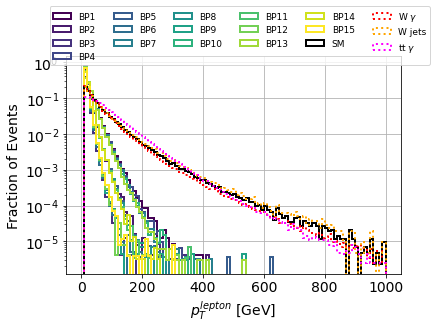

In [35]:
for i in range(len(photon_NP)):
    weights = np.ones_like(lepton_NP[i][:,0])/len(lepton_NP[i][:,0])
    plt.hist(lepton_NP[i][:,0], weights=weights, bins=100, range=[0,1000], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(lepton_SM[:,0])/len(lepton_SM[:,0])
plt.hist(lepton_SM[:,0], weights=weights, bins=100, range=[0,1000], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(lepton_Wgamma[:,0])/len(lepton_Wgamma[:,0])
plt.hist(lepton_Wgamma[:,0], weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(lepton_Wjets[:,0])/len(lepton_Wjets[:,0])
plt.hist(lepton_Wjets[:,0], weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(lepton_ttgamma[:,0])/len(lepton_ttgamma[:,0])
plt.hist(lepton_ttgamma[:,0], weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$p_T^{lepton}$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1.1, 1.25), ncol = 6)
plt.savefig('../graph/pt_leadingLepton_dist.png', bbox_inches='tight')

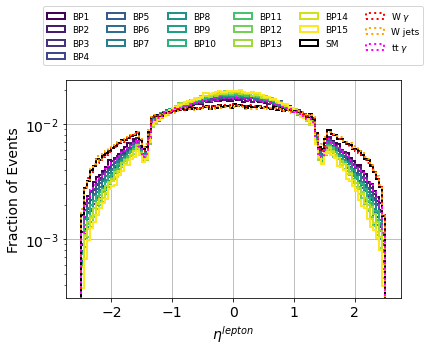

In [36]:
for i in range(len(photon_NP)):
    weights = np.ones_like(lepton_NP[i][:,1])/len(lepton_NP[i][:,1])
    plt.hist(lepton_NP[i][:,1], weights=weights, bins=100, lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(lepton_SM[:,1])/len(lepton_SM[:,1])
plt.hist(lepton_SM[:,1], weights=weights, bins=100, lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(lepton_Wgamma[:,1])/len(lepton_Wgamma[:,1])
plt.hist(lepton_Wgamma[:,1], weights=weights, bins=100, lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(lepton_Wjets[:,1])/len(lepton_Wjets[:,1])
plt.hist(lepton_Wjets[:,1], weights=weights, bins=100, lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(lepton_ttgamma[:,1])/len(lepton_ttgamma[:,1])
plt.hist(lepton_ttgamma[:,1], weights=weights, bins=100, lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$\eta^{lepton}$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='lower center',fontsize=9,bbox_to_anchor=(0.5, 1.05), ncol = 6)
plt.savefig('../graph/pseudoRapidity_leadingLepton_dist.png', bbox_inches='tight')

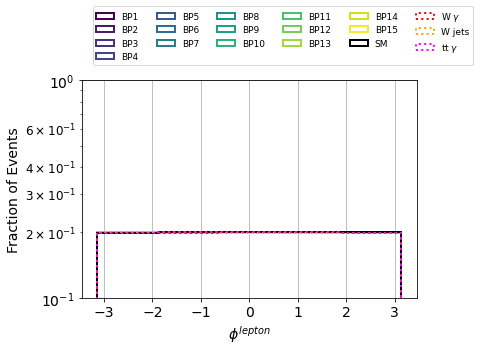

In [37]:
for i in range(len(photon_NP)):
    weights = np.ones_like(lepton_NP[i][:,2])/len(lepton_NP[i][:,2])
    plt.hist(lepton_NP[i][:,2], weights=weights, bins=5, lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(lepton_SM[:,2])/len(lepton_SM[:,2])
plt.hist(lepton_SM[:,2], weights=weights, bins=5, lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(lepton_Wgamma[:,2])/len(lepton_Wgamma[:,2])
plt.hist(lepton_Wgamma[:,2], weights=weights, bins=5, lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(lepton_Wjets[:,2])/len(lepton_Wjets[:,2])
plt.hist(lepton_Wjets[:,2], weights=weights, bins=5, lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(lepton_ttgamma[:,2])/len(lepton_ttgamma[:,2])
plt.hist(lepton_ttgamma[:,2], weights=weights, bins=5, lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$\phi^{lepton}$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0.1,1)
plt.yscale('log')
plt.legend(loc='lower center',fontsize=9,bbox_to_anchor=(0.6, 1.05), ncol = 6)
plt.savefig('../graph/phi_leadingLepton_dist.png', bbox_inches='tight')

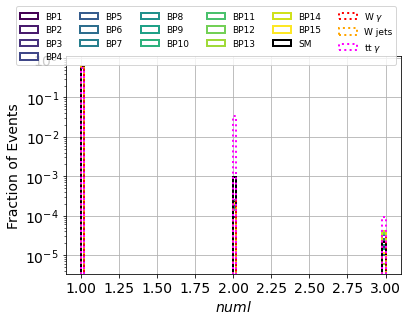

In [38]:
for i in range(len(lepton_NP)):
    weights = np.ones_like(lepton_NP[i][:,3])/len(lepton_NP[i][:,3])
    plt.hist(lepton_NP[i][:,3], weights=weights, bins=100, range=[1, np.max(lepton_SM[:,3])], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(lepton_SM[:,3])/len(lepton_SM[:,3])
plt.hist(lepton_SM[:,3], weights=weights, bins=100, range=[1, np.max(lepton_SM[:,3])], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(photon_Wgamma[:,3])/len(photon_Wgamma[:,3])
plt.hist(lepton_Wgamma[:,3], weights=weights, bins=100, range=[1, np.max(lepton_SM[:,3])], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(photon_Wjets[:,3])/len(photon_Wjets[:,0])
plt.hist(lepton_Wjets[:,3], weights=weights, bins=100, range=[1, np.max(lepton_SM[:,3])], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(lepton_ttgamma[:,3])/len(photon_ttgamma[:,0])
plt.hist(lepton_ttgamma[:,3], weights=weights, bins=100, range=[1, np.max(lepton_SM[:,3])], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()
plt.xlabel(r"$num l$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1., 1.25), ncol = 6)
plt.savefig('../graph/num_leptons_dist.png', bbox_inches='tight')

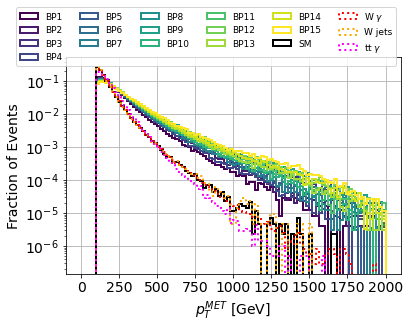

In [39]:
for i in range(len(photon_NP)):
    weights = np.ones_like(MET_NP[i][:,0])/len(MET_NP[i][:,0])
    plt.hist(MET_NP[i][:,0], weights=weights, bins=100, range=[0,2000], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(MET_SM[:,0])/len(MET_SM[:,0])
plt.hist(MET_SM[:,0], weights=weights, bins=100, range=[0,2000], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(MET_Wgamma[:,0])/len(MET_Wgamma[:,0])
plt.hist(MET_Wgamma[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(MET_Wjets[:,0])/len(MET_Wjets[:,0])
plt.hist(MET_Wjets[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(MET_ttgamma[:,0])/len(MET_ttgamma[:,0])
plt.hist(MET_ttgamma[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$p_T^{MET}$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1., 1.25), ncol = 6)
plt.savefig('../graph/pt_MET_dist.png', bbox_inches='tight')

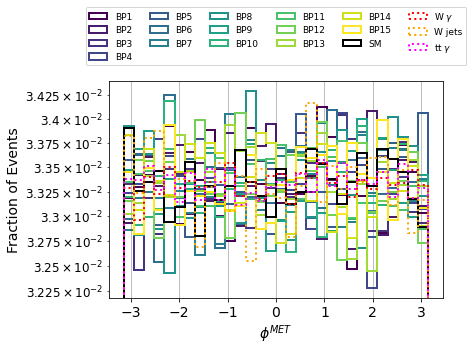

In [40]:
for i in range(len(photon_NP)):
    weights = np.ones_like(MET_NP[i][:,2])/len(MET_NP[i][:,2])
    plt.hist(MET_NP[i][:,2], weights=weights, bins=30, lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(MET_SM[:,2])/len(MET_SM[:,2])
plt.hist(MET_SM[:,2], weights=weights, bins=30, lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(MET_Wgamma[:,2])/len(MET_Wgamma[:,2])
plt.hist(MET_Wgamma[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(MET_Wjets[:,2])/len(MET_Wjets[:,2])
plt.hist(MET_Wjets[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(MET_ttgamma[:,2])/len(MET_ttgamma[:,2])
plt.hist(MET_ttgamma[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$\phi^{MET}$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='lower center',fontsize=9,bbox_to_anchor=(0.5, 1.05), ncol = 6)
plt.savefig('../graph/phi_MET_dist.png', bbox_inches='tight')

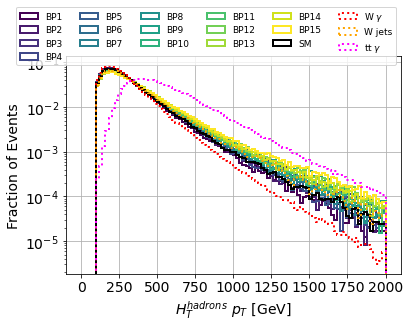

In [41]:
for i in range(len(photon_NP)):
    weights = np.ones_like(hadinfo_NP[i][:,0])/len(hadinfo_NP[i][:,0])
    plt.hist(hadinfo_NP[i][:,0], weights=weights, bins=100, range=[0,2000], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)
    
weights = np.ones_like(hadinfo_SM[:,0])/len(hadinfo_SM[:,0])
plt.hist(hadinfo_SM[:,0], weights=weights, bins=100, range=[0,2000], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(hadinfo_Wgamma[:,0])/len(hadinfo_Wgamma[:,0])
plt.hist(hadinfo_Wgamma[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(hadinfo_Wjets[:,0])/len(hadinfo_Wjets[:,0])
plt.hist(hadinfo_Wjets[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(hadinfo_ttgamma[:,0])/len(hadinfo_ttgamma[:,0])
plt.hist(hadinfo_ttgamma[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$H_T^{hadrons}$ $p_T$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1., 1.25), ncol = 6)
plt.savefig('../graph/HadInfo_dist.png', bbox_inches='tight')

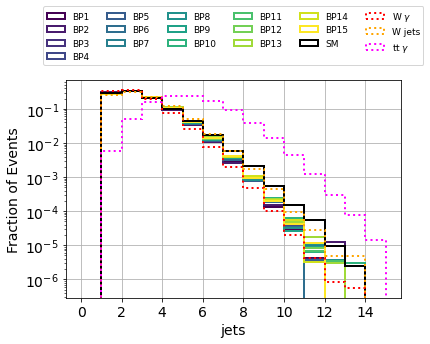

In [42]:
for i in range(len(photon_NP)):
    weights = np.ones_like(hadinfo_NP[i][:,1])/len(hadinfo_NP[i][:,1])
    plt.hist(hadinfo_NP[i][:,1], weights=weights, bins=15, range=[0,15], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)
    
weights = np.ones_like(hadinfo_SM[:,1])/len(hadinfo_SM[:,1])
plt.hist(hadinfo_SM[:,1], weights=weights, bins=15, range=[0,15], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(hadinfo_Wgamma[:,1])/len(hadinfo_Wgamma[:,1])
plt.hist(hadinfo_Wgamma[:,1], weights=weights, bins=15, range=[0,15], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(hadinfo_Wjets[:,1])/len(hadinfo_Wjets[:,1])
plt.hist(hadinfo_Wjets[:,1], weights=weights, bins=15, range=[0,15], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(hadinfo_ttgamma[:,1])/len(hadinfo_ttgamma[:,1])
plt.hist(hadinfo_ttgamma[:,1], weights=weights, bins=15, range=[0,15], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"jets",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='lower center',fontsize=9,bbox_to_anchor=(0.5, 1.05), ncol = 6)
plt.savefig('../graph/jets_dist.png', bbox_inches='tight')

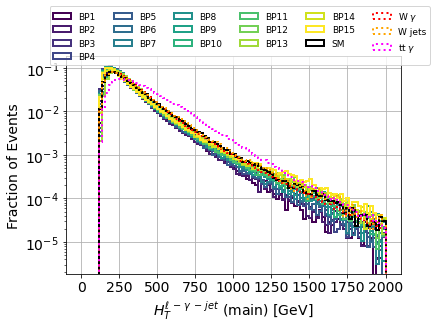

In [43]:
for i in range(len(photon_NP)):
    weights = np.ones_like(HT_main_NP[i])/len(HT_main_NP[i])
    plt.hist(HT_main_NP[i], weights=weights, bins=100, range=[0,2000], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)
    
weights = np.ones_like(HT_main_SM)/len(HT_main_SM)
plt.hist(HT_main_SM, weights=weights, bins=100, range=[0,2000], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(HT_main_Wgamma)/len(HT_main_Wgamma)
plt.hist(HT_main_Wgamma, weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(HT_main_Wjets)/len(HT_main_Wjets)
plt.hist(HT_main_Wjets, weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(HT_main_ttgamma)/len(HT_main_ttgamma)
plt.hist(HT_main_ttgamma, weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$H_T^{\ell \,-\, \gamma \,-\, jet}$ (main) [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1.1, 1.25), ncol = 6)
plt.savefig('../graph/Ht_dist.png', bbox_inches='tight')

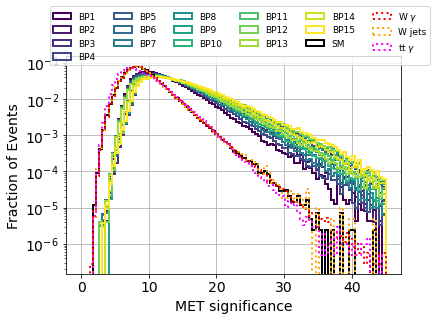

In [44]:
for i in range(len(photon_NP)):
    weights = np.ones_like(MET_sig_NP[i])/len(MET_sig_NP[i])
    plt.hist(MET_sig_NP[i], weights=weights, bins=100, range=[0,45], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)
    
weights = np.ones_like(MET_sig_SM)/len(MET_sig_SM)
plt.hist(MET_sig_SM, weights=weights, bins=100, range=[0,45], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(MET_sig_Wgamma)/len(MET_sig_Wgamma)
plt.hist(MET_sig_Wgamma, weights=weights, bins=100, range=[0,45], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(MET_sig_Wjets)/len(MET_sig_Wjets)
plt.hist(MET_sig_Wjets, weights=weights, bins=100, range=[0,45], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(MET_sig_ttgamma)/len(MET_sig_ttgamma)
plt.hist(MET_sig_ttgamma, weights=weights, bins=100, range=[0,45], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"MET significance",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1.1, 1.25), ncol = 6)
plt.savefig('../graph/MET_significance_dist.png', bbox_inches='tight')

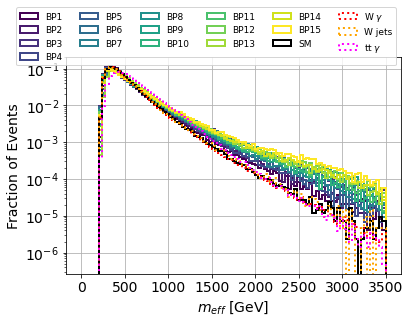

In [45]:
for i in range(len(photon_NP)):
    weights = np.ones_like(m_eff_NP[i])/len(m_eff_NP[i])
    plt.hist(m_eff_NP[i], weights=weights, bins=100, range=[0,3500], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)
    
weights = np.ones_like(m_eff_SM)/len(m_eff_SM)
plt.hist(m_eff_SM, weights=weights, bins=100, range=[0,3500], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(m_eff_Wgamma)/len(m_eff_Wgamma)
plt.hist(m_eff_Wgamma, weights=weights, bins=100, range=[0,3500], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(m_eff_Wjets)/len(m_eff_Wjets)
plt.hist(m_eff_Wjets, weights=weights, bins=100, range=[0,3500], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(m_eff_ttgamma)/len(m_eff_ttgamma)
plt.hist(m_eff_ttgamma, weights=weights, bins=100, range=[0,3500], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$m_{eff}$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1., 1.25), ncol = 6)
plt.savefig('../graph/Meff_dist.png', bbox_inches='tight')

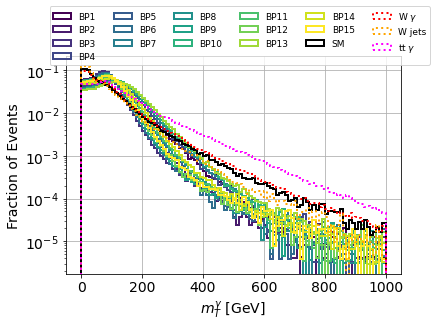

In [46]:
for i in range(len(photon_NP)):
    weights = np.ones_like(mT_photon_NP[i])/len(mT_photon_NP[i])
    plt.hist(mT_photon_NP[i], weights=weights, bins=100, range=[0,1000], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)
    
weights = np.ones_like(mT_photon_SM)/len(mT_photon_SM)
plt.hist(mT_photon_SM, weights=weights, bins=100, range=[0,1000], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(mT_photon_Wgamma)/len(mT_photon_Wgamma)
plt.hist(mT_photon_Wgamma, weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(mT_photon_Wjets)/len(mT_photon_Wjets)
plt.hist(mT_photon_Wjets, weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(mT_photon_ttgamma)/len(mT_photon_ttgamma)
plt.hist(mT_photon_ttgamma, weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$m_{T}^{\gamma}$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1.1, 1.25), ncol = 6)
plt.savefig('../graph/mt_photon_dist.png', bbox_inches='tight')

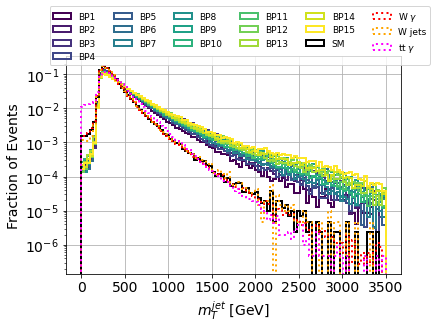

In [47]:
for i in range(len(photon_NP)):
    weights = np.ones_like(mT_jet_NP[i])/len(mT_jet_NP[i])
    plt.hist(mT_jet_NP[i], weights=weights, bins=100, range=[0,3500], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)
    
weights = np.ones_like(mT_jet_SM)/len(mT_jet_SM)
plt.hist(mT_jet_SM, weights=weights, bins=100, range=[0,3500], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(mT_jet_Wgamma)/len(mT_jet_Wgamma)
plt.hist(mT_jet_Wgamma, weights=weights, bins=100, range=[0,3500], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(mT_jet_Wjets)/len(mT_jet_Wjets)
plt.hist(mT_jet_Wjets, weights=weights, bins=100, range=[0,3500], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(mT_jet_ttgamma)/len(mT_jet_ttgamma)
plt.hist(mT_jet_ttgamma, weights=weights, bins=100, range=[0,3500], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$m_{T}^{jet}$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1.1, 1.25), ncol = 6)
plt.savefig('../graph/mt_Jet_dist.png', bbox_inches='tight')

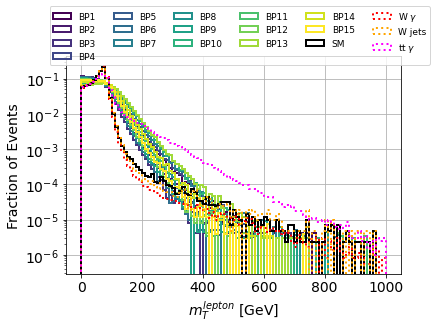

In [48]:
for i in range(len(photon_NP)):
    weights = np.ones_like(mT_lepton_NP[i])/len(mT_lepton_NP[i])
    plt.hist(mT_lepton_NP[i], weights=weights, bins=100, range=[0,1000], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)
    
weights = np.ones_like(mT_lepton_SM)/len(mT_lepton_SM)
plt.hist(mT_lepton_SM, weights=weights, bins=100, range=[0,1000], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(mT_lepton_Wgamma)/len(mT_lepton_Wgamma)
plt.hist(mT_lepton_Wgamma, weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(mT_lepton_Wjets)/len(mT_lepton_Wjets)
plt.hist(mT_lepton_Wjets, weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(mT_lepton_ttgamma)/len(mT_lepton_ttgamma)
plt.hist(mT_lepton_ttgamma, weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$m_{T}^{lepton}$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1.1, 1.25), ncol = 6)
plt.savefig('../graph/mt_Lepton_dist.png', bbox_inches='tight')

## Correlation Plots

In [107]:
# bp correspond to benchmark points (bp + 1) !!!!
bp = 1
nobs = 150_000

df = pd.DataFrame()

lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ (had) [GeV]', 'num_jets',
       '$H_T$ (main) [GeV]', 'MET sig [GeV]', '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       '$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       '$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

df[lst[0]]= np.concatenate([photon_SM[:,0],photon_NP[bp][:nobs,0]])
df[lst[1]]= np.concatenate([photon_SM[:,1],photon_NP[bp][:nobs,1]])
df[lst[2]]= np.concatenate([photon_SM[:,2],photon_NP[bp][:nobs,2]])

df[lst[3]]= np.concatenate([jet_SM[:,0],jet_NP[bp][:nobs,0]])
df[lst[4]]= np.concatenate([jet_SM[:,1],jet_NP[bp][:nobs,1]])
df[lst[5]]= np.concatenate([jet_SM[:,2],jet_NP[bp][:nobs,2]])

df[lst[6]]= np.concatenate([lepton_SM[:,0],lepton_NP[bp][:nobs,0]])
df[lst[7]]= np.concatenate([lepton_SM[:,1],lepton_NP[bp][:nobs,1]])
df[lst[8]]= np.concatenate([lepton_SM[:,2],lepton_NP[bp][:nobs,2]])

df[lst[9]]= np.concatenate([MET_SM[:,0],MET_NP[bp][:nobs,0]])
df[lst[10]]= np.concatenate([MET_SM[:,2],MET_NP[bp][:nobs,2]])

df[lst[11]]= np.concatenate([hadinfo_SM[:,0],hadinfo_NP[bp][:nobs,0]])
df[lst[12]]= np.concatenate([hadinfo_SM[:,1],hadinfo_NP[bp][:nobs,1]])

df[lst[13]]= np.concatenate([HT_main_SM,HT_main_NP[bp][:nobs]])
df[lst[14]]= np.concatenate([MET_sig_SM,MET_sig_NP[bp][:nobs]])
df[lst[15]]= np.concatenate([m_eff_SM,m_eff_NP[bp][:nobs]])

df[lst[16]]= np.concatenate([mT_photon_SM,mT_photon_NP[bp][:nobs]])
df[lst[17]]= np.concatenate([mT_jet_SM,mT_jet_NP[bp][:nobs]])
df[lst[18]]= np.concatenate([mT_lepton_SM,mT_lepton_NP[bp][:nobs]])

df[lst[19]]= np.concatenate([phi_MET_photon_SM,phi_MET_photon_NP[bp][:nobs]])
df[lst[20]]= np.concatenate([phi_MET_jet_SM,phi_MET_jet_NP[bp][:nobs]])
df[lst[21]]= np.concatenate([phi_MET_lepton_SM,phi_MET_lepton_NP[bp][:nobs]])

df[lst[22]]= np.concatenate([deltaR_photon_jet_SM,deltaR_photon_jet_NP[bp][:nobs]])
df[lst[23]]= np.concatenate([deltaR_photon_lepton_SM,deltaR_photon_lepton_NP[bp][:nobs]])
df[lst[24]]= np.concatenate([deltaR_lepton_jet_SM,deltaR_lepton_jet_NP[bp][:nobs]])

df[lst[25]]= np.concatenate([np.zeros(len(photon_SM)),np.ones(len(photon_NP[bp][:nobs]))])

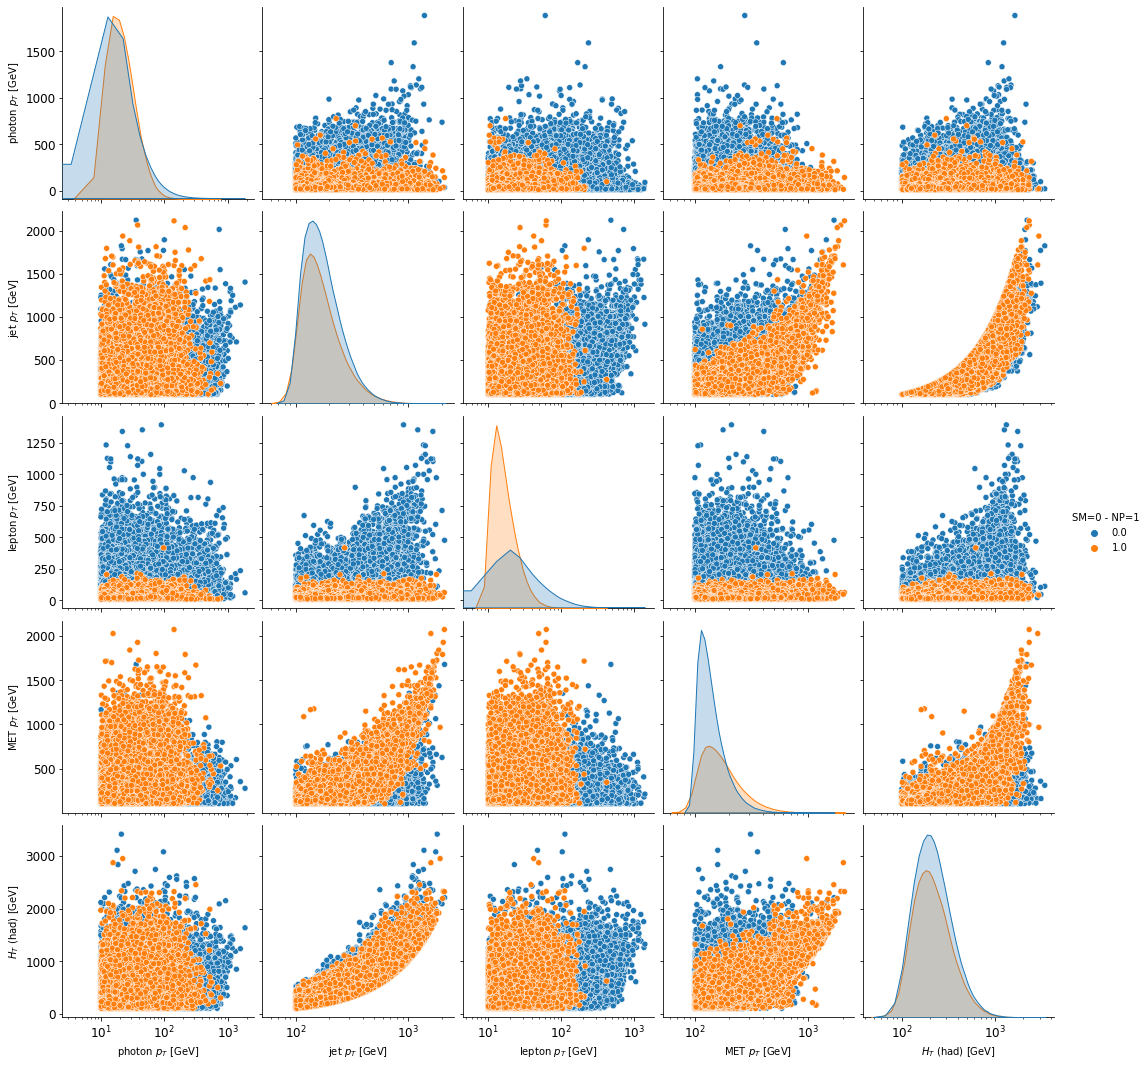

In [108]:
g = sns.pairplot(df, hue="SM=0 - NP=1", height=3,
                 x_vars=[lst[0],lst[3],lst[6],lst[9],lst[11]],
                 y_vars=[lst[0],lst[3],lst[6],lst[9],lst[11]])

log_columns = [lst[0],lst[3],lst[6],lst[9],lst[11]]

for ax in g.axes.flat:
    if ax.get_xlabel() in log_columns:
        ax.set(xscale="log")

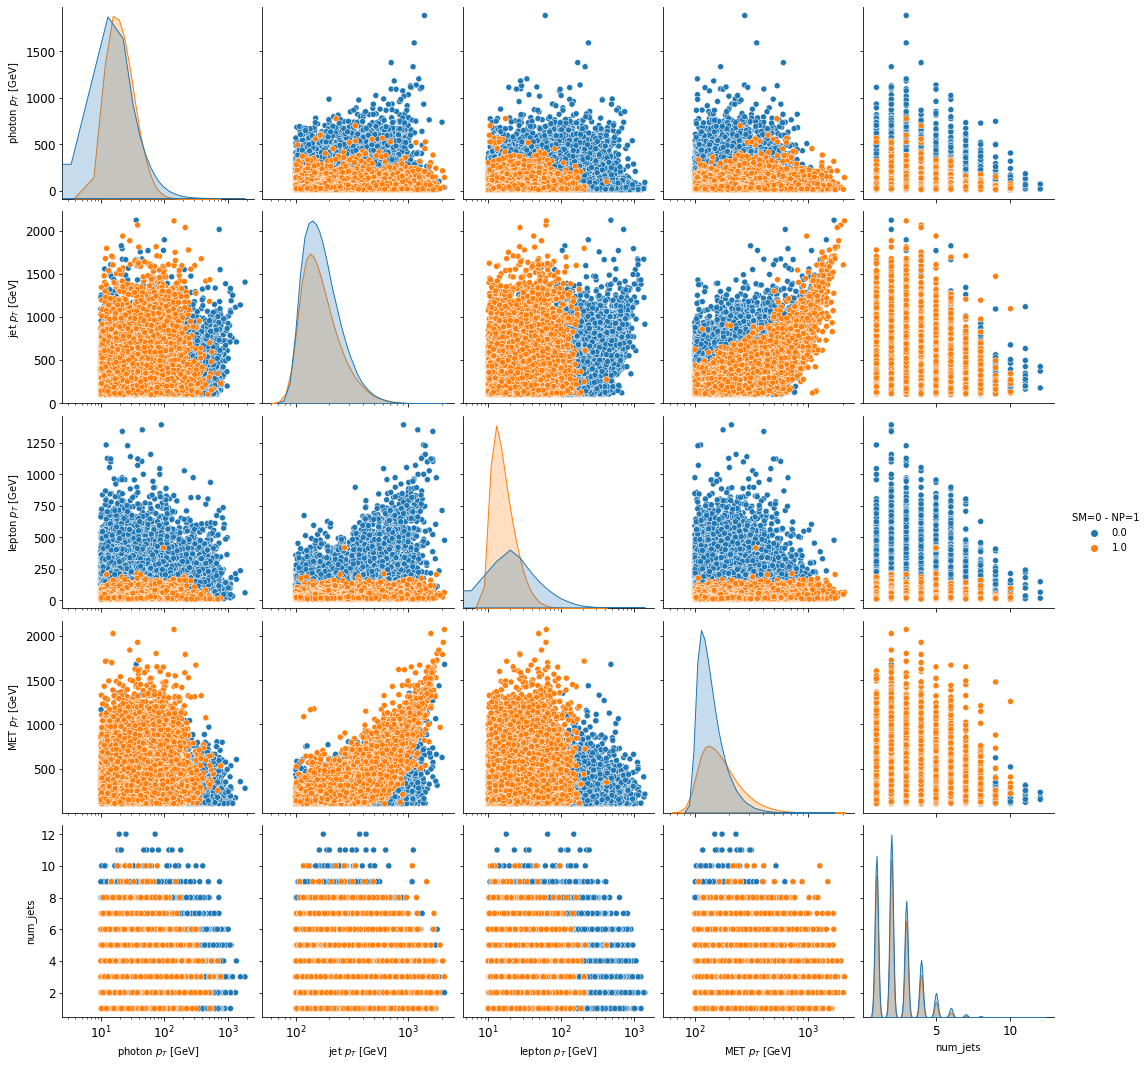

In [109]:
g = sns.pairplot(df, hue="SM=0 - NP=1", height=3,
                 x_vars=[lst[0],lst[3],lst[6],lst[9],lst[12]],
                 y_vars=[lst[0],lst[3],lst[6],lst[9],lst[12]])

log_columns = [lst[0],lst[3],lst[6],lst[9]]

for ax in g.axes.flat:
    if ax.get_xlabel() in log_columns:
        ax.set(xscale="log")

# Analysis

## training

In [13]:
# LOW LEVEL VARIABLES ----------------------
# photon_SM[:,0] : PT
# photon_SM[:,1] : eta
# photon_SM[:,2] : phi

print(photon_SM.shape)
print(jet_SM.shape)
print(lepton_SM.shape)
print(MET_SM.shape)
#-------------------------------------------


(250000, 4)
(250000, 3)
(250000, 4)
(250000, 3)


In [14]:
# bp correspond to benchmark points (bp + 1) !!!!
bp = 0

# LOW LEVEL VARIABLES ----------------------
# photon_NP[bp][:,0] : PT
# photon_NP[bp][:,1] : eta
# photon_NP[bp][:,2] : phi

print(photon_NP[bp].shape)
print(jet_NP[bp].shape)
print(lepton_NP[bp].shape)
print(MET_NP[bp].shape)
#-------------------------------------------

(238160, 4)
(238160, 3)
(238160, 4)
(238160, 3)


In [15]:
nobs = np.min( (len(photon_SM), len(photon_NP[bp])) )
nobs

238160

In [25]:
bkg_flag[SM_indices]

array([2., 2., 2., ..., 2., 2., 1.])

In [17]:
df = pd.DataFrame()

lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton',
       'MET $p_T$ [GeV]', 'MET $\phi$', 'num_jets', 
       'SM=0 - NP=1']

SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

df[lst[0]]= np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][:nobs,0]])
df[lst[1]]= np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][:nobs,1]])
df[lst[2]]= np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][:nobs,2]])
df[lst[3]]= np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][:nobs,3]])

df[lst[4]]= np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][:nobs,0]])
df[lst[5]]= np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][:nobs,1]])
df[lst[6]]= np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][:nobs,2]])

df[lst[7]]= np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][:nobs,0]])
df[lst[8]]= np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][:nobs,1]])
df[lst[9]]= np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][:nobs,2]])
df[lst[10]]= np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][:nobs,3]])

df[lst[11]]= np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][:nobs,0]])
df[lst[12]]= np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][:nobs,2]])

df[lst[13]]= np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][:nobs,1]])

df['bkg_flag']= np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][:nobs]))) )

df[lst[14]]= np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][:nobs]))])

df_array = np.asarray(df)
df

,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,num lepton,MET $p_T$ [GeV],MET $\phi$,num_jets,bkg_flag,SM=0 - NP=1
0,72.70,0.497,-1.301,1.0,297.23,0.233,1.632,19.51,-0.124,-0.753,1.0,271.91,-1.310,3.0,2.0,0.0
1,109.79,1.682,-0.261,1.0,265.88,-1.625,3.051,34.65,1.255,0.910,0.0,110.11,1.218,2.0,2.0,0.0
2,20.98,1.352,-1.404,1.0,277.27,0.469,1.692,130.69,1.346,-1.355,1.0,120.19,-1.533,1.0,2.0,0.0
3,34.50,0.608,1.850,1.0,446.29,-0.099,-1.122,205.57,1.088,1.882,1.0,192.83,2.156,1.0,1.0,0.0
4,71.64,1.035,2.249,1.0,211.88,0.345,2.744,251.04,0.642,-0.197,0.0,108.04,-0.592,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476315,45.67,0.262,-2.240,1.0,303.61,-1.577,1.250,25.54,-0.577,-0.883,1.0,231.70,-1.994,2.0,0.0,1.0
476316,33.13,0.660,1.200,1.0,218.63,-1.530,-0.333,15.07,1.772,-2.669,1.0,136.40,2.841,4.0,0.0,1.0
476317,76.92,0.187,-1.864,1.0,227.64,-0.029,1.323,17.11,0.778,-0.086,0.0,166.60,-1.916,1.0,0.0,1.0
476318,89.06,1.678,-1.271,1.0,193.55,0.503,2.000,17.80,2.123,1.301,1.0,157.76,-1.155,2.0,0.0,1.0


In [18]:
nobs = len(df_array)

train_size = int(0.80 * nobs)
#%test_size  = int(0.15 * nobs)
val_size   = nobs - train_size #%- test_size 

np.random.seed(91218)
random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

train_indices = random_indices[:train_size]
#%test_indices  = random_indices[train_size:(train_size + test_size)]
#%val_indices   = random_indices[(train_size + test_size):]
val_indices   = random_indices[train_size:]

In [26]:
X_train        = df_array[train_indices, :14]
bkg_flag_train = df_array[train_indices, 14]
y_mon_train    = df_array[train_indices, -1]

X_val        = df_array[val_indices, :14]
bkg_flag_val = df_array[val_indices, 14]
y_mon_val    = df_array[val_indices, -1]

In [28]:
ind_signal_train  = np.where(bkg_flag_train == 0)[0]
ind_wgamma_train  = np.where(bkg_flag_train == 1)[0] # W gamma
ind_wjets_train   = np.where(bkg_flag_train == 2)[0] # W jets
ind_ttgamma_train = np.where(bkg_flag_train == 3)[0] # tt gamma

if(len(ind_wgamma_train) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma_train), Wgamma_expected))
if(len(ind_ttgamma_train) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma_train), ttgamma_expected))
if(len(ind_wjets_train) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets_train), Wjets_expected))

In [29]:
# to normalize
x_scaler = preprocessing.MinMaxScaler()
x_scaler = x_scaler.fit(X_train)

X_mon_train = x_scaler.transform(X_train)
#%X_mon_test  = x_scaler.transform(X_test)
X_mon_val   = x_scaler.transform(X_val)

In [30]:
ind_signal  = np.where(bkg_flag_val == 0)[0]
ind_wgamma  = np.where(bkg_flag_val == 1)[0] # W gamma
ind_wjets   = np.where(bkg_flag_val == 2)[0] # W jets
ind_ttgamma = np.where(bkg_flag_val == 3)[0] # tt gamma

In [31]:
if(len(ind_wgamma) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma), Wgamma_expected))
if(len(ind_ttgamma) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma), ttgamma_expected))
if(len(ind_wjets) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets), Wjets_expected))

There are less Wgamma events 22966 than expected 58462.347349489064
There are less ttgamma events 1068 than expected 2877.3979008
There are less Wjets events 23447 than expected 60057.888696312366


In [32]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators  = 500,
    learning_rate = 0.1,
    reg_lambda    = 0.0, reg_alpha = 0.0,
    early_stopping_rounds = 50,#early stopping
    eval_metric = 'logloss',
    gamma = 0.0, objective = 'binary:logistic',
    max_depth = 5)

# FIT
classifier.fit(X_mon_train, y_mon_train, 
               eval_set = [(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
               verbose  =True)

# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_val).T[1]

[0]	validation_0-logloss:0.66608	validation_1-logloss:0.66630
[1]	validation_0-logloss:0.64361	validation_1-logloss:0.64391
[2]	validation_0-logloss:0.62478	validation_1-logloss:0.62524
[3]	validation_0-logloss:0.60874	validation_1-logloss:0.60934
[4]	validation_0-logloss:0.59537	validation_1-logloss:0.59613
[5]	validation_0-logloss:0.58340	validation_1-logloss:0.58430
[6]	validation_0-logloss:0.57349	validation_1-logloss:0.57446
[7]	validation_0-logloss:0.56482	validation_1-logloss:0.56590
[8]	validation_0-logloss:0.55702	validation_1-logloss:0.55829
[9]	validation_0-logloss:0.55056	validation_1-logloss:0.55191
[10]	validation_0-logloss:0.54484	validation_1-logloss:0.54627
[11]	validation_0-logloss:0.53957	validation_1-logloss:0.54114
[12]	validation_0-logloss:0.53519	validation_1-logloss:0.53689
[13]	validation_0-logloss:0.53117	validation_1-logloss:0.53300
[14]	validation_0-logloss:0.52779	validation_1-logloss:0.52973
[15]	validation_0-logloss:0.52468	validation_1-logloss:0.52671
[1

In [33]:
print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('')


X_mon_train :  (381056, 14)
y_mon_train :  (381056,)
X_mon_val :  (95264, 14)
y_mon_val :  (95264,)



In [34]:
# Let's estimate the ROC Curve
nvals = 50
tpr_total   = np.zeros(nvals) 
fpr_total   = np.zeros(nvals) 
tpr_ttgamma = np.zeros(nvals) 
fpr_ttgamma = np.zeros(nvals) 
tpr_wgamma  = np.zeros(nvals) 
fpr_wgamma  = np.zeros(nvals) 
tpr_wjets   = np.zeros(nvals) 
fpr_wjets   = np.zeros(nvals) 

for ith, th in enumerate(np.linspace(0,1, nvals)):
    tp = np.where( (bkg_flag_val == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_val != 0) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_val != 0) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_val == 0) & (y_pred_xg < th) )[0]

    tpr_total[ith] = len(tp) / (len(tp) + len(fn))
    fpr_total[ith] = len(fp) / (len(fp) + len(tn))
    auc_total = auc(fpr_total, tpr_total)
    
    tp = np.where( (bkg_flag_val == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_val == 1) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_val == 1) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_val == 0) & (y_pred_xg < th) )[0]

    tpr_wgamma[ith] = len(tp) / (len(tp) + len(fn))
    fpr_wgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_wgamma = auc(fpr_wgamma, tpr_wgamma)
    
    tp = np.where( (bkg_flag_val == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_val == 2) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_val == 2) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_val == 0) & (y_pred_xg < th) )[0]

    tpr_wjets[ith] = len(tp) / (len(tp) + len(fn))
    fpr_wjets[ith] = len(fp) / (len(fp) + len(tn))
    auc_wjets = auc(fpr_wjets, tpr_wjets)
    
    tp = np.where( (bkg_flag_val == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_val == 3) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_val == 3) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_val == 0) & (y_pred_xg < th) )[0]

    tpr_ttgamma[ith] = len(tp) / (len(tp) + len(fn))
    fpr_ttgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_ttgamma = auc(fpr_ttgamma, tpr_ttgamma)

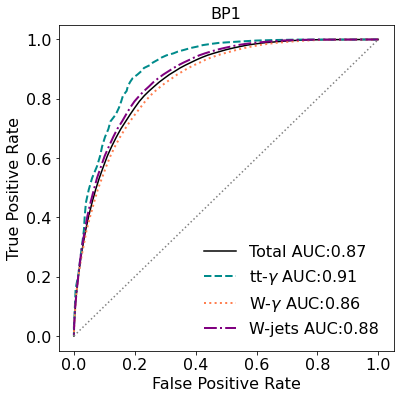

In [38]:
plt.figure(figsize=(6, 6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.plot(fpr_total, tpr_total, c = 'black', label = 'Total AUC:{:.2f}'.format(auc_total))
plt.plot(fpr_ttgamma, tpr_ttgamma, c = 'darkcyan', linestyle = '--', lw = 2, label = 'tt-$\gamma$ AUC:{:.2f}'.format(auc_ttgamma))
plt.plot(fpr_wgamma, tpr_wgamma, c = 'coral', linestyle = ':', lw = 2, label = 'W-$\gamma$ AUC:{:.2f}'.format(auc_wgamma))
plt.plot(fpr_wjets, tpr_wjets, c = 'purple', linestyle = '-.', lw = 2, label = 'W-jets AUC:{:.2f}'.format(auc_wjets))
plt.legend(frameon=False,fontsize=16)
plt.ylabel("True Positive Rate",fontsize=16)
plt.xlabel("False Positive Rate",fontsize=16)
plt.plot([0,1],[0,1],ls=":",color="grey")
plt.title(r"BP" + str(bp + 1),fontsize=16)

plt.savefig('../graph/ROC_BP' + str(bp + 1) + '_lowLevel.png', bbox_inches='tight')

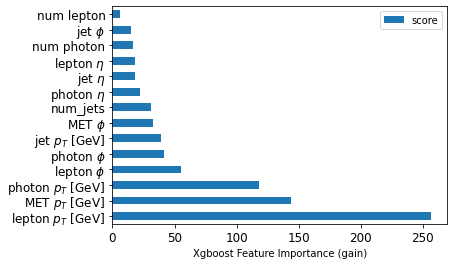

In [37]:
fig, ax = plt.subplots()

feature_important = classifier.get_booster().get_score(importance_type='gain')
values = list(feature_important.values())

data = pd.DataFrame(data=values, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(14, columns="score").plot(kind='barh', ax = ax) ## plot top 20 features

ax.set_xlabel("Xgboost Feature Importance (gain)")
ax.set_yticklabels(np.asarray(lst)[np.argsort(values)[::-1][:14]])

plt.savefig('../graph/BP' + str(bp + 1) + '_featureImportance_lowLevel.png', bbox_inches='tight')

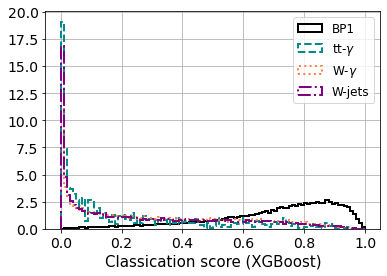

In [39]:
plt.hist(y_pred_xg[np.where(bkg_flag_val == 0)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = 'black', label = 'BP' + str(bp + 1), lw = 2)
plt.hist(y_pred_xg[np.where(bkg_flag_val == 3)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = 'darkcyan', linestyle = '--', lw = 2, label = 'tt-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_val == 1)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = 'coral', linestyle = ':', lw = 2, label = 'W-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_val == 2)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = 'purple', linestyle = '-.', lw = 2, label = 'W-jets')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
#plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.savefig('../graph/MLOutput_dist_BP' + str(bp + 1) + '_lowLevel.png', bbox_inches="tight")

In [40]:
pred_XG_NP = y_pred_xg[np.where(bkg_flag_val == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_val != 0)[0]]

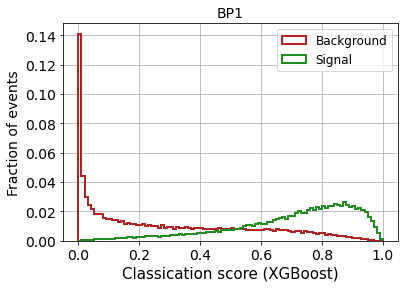

In [41]:
# XGBoost

########################
# CLASSIFICATION SCORE #
########################
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.title('BP' + str(bp + 1), fontsize=14)

plt.savefig('../graph/' + '2monian-output_lowLevel.pdf', format="pdf", bbox_inches="tight")

In [42]:
S_expected[bp] / np.sqrt(B_expected)

0.5796876138715118

## Working points

In [43]:
# Working point
treshold = np.linspace(0.6, 1, 11)

Sexp = []
Bexp = []
for ith, th in enumerate(treshold):
    signalok = len(np.where( y_pred_xg[np.where(bkg_flag_val == 0)[0]] > th)[0])
    backok   = len(np.where( y_pred_xg[np.where(bkg_flag_val != 0)[0]] > th)[0])

    frac_sig = signalok / len(pred_XG_NP)
    frac_bkg = backok / len(pred_XG_SM)

    Sexp.append(S_expected[bp] * frac_sig)
    Bexp.append(B_expected * frac_bkg)

    #print('treshold: ', th)
    #print('Sexp: ', Sexp[ith])
    #print('Bexp: ', Bexp[ith])
    #print('SsqrtB: ', Sexp[ith] / np.sqrt(Bexp[ith]))
    #print('Sig stat full: ', ( 2.* ( (Sexp[ith] + Bexp[ith]) * np.log(1 + (Sexp/[ith]Bexp[ith]) ) - Sexp[ith] ) )**0.5 )
Sexp = np.asarray(Sexp)
Bexp = np.asarray(Bexp)

SsqrtB = Sexp / np.sqrt(Bexp)
Sig_full = ( 2.* ( (Sexp + Bexp) * np.log(1 + (Sexp/Bexp) ) - Sexp ) )**0.5 

/tmp/ipykernel_188909/1077839631.py:24: RuntimeWarning: invalid value encountered in true_divide
  SsqrtB = Sexp / np.sqrt(Bexp)
/tmp/ipykernel_188909/1077839631.py:25: RuntimeWarning: invalid value encountered in true_divide
  Sig_full = ( 2.* ( (Sexp + Bexp) * np.log(1 + (Sexp/Bexp) ) - Sexp ) )**0.5


## Binned likelihood (super experiment)

In [44]:
##############
# PARAMETERS #
##############

# requested number of ensembles
n_ensembles = 5000


## LQ up 1400 GeV:
#S_expected = 7 # 6.6095293118432

# ratio S_expected/B_expected (signal ratio)
#SB_ratio = [0.0006, 0.001, 0.0016, 0.0025, 0.005, 0.0075, 0.01, 0.025]

# SOME USEFUL DERIVATED PARAMETERS:

# S/\sqrt{B}
SB_ratio = S_expected[bp]/(1.*B_expected) 
# S/\sqrt{B}
SsqrtB = S_expected[bp]/(B_expected)**0.5

In [45]:
# Les't use an integer number of possible ensembles
N_ensembles_back = len(pred_XG_SM) / B_expected
N_events_back = N_ensembles_back * B_expected

N_ensembles_sig = len(pred_XG_NP) / S_expected[bp]
N_events_sig = N_ensembles_sig * S_expected[bp]
    
bins = np.linspace(10, 25, 15).astype('int')
Z_bins = np.zeros(len(bins))

for ib, nbin in enumerate(bins):
    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(nbin), range = [[0, 1]])
    # now divide by the number of possible ensembles
    back_prom = hist_back.T.ravel()/N_ensembles_back

    # same for signal
    hist_sig, _ = np.histogramdd([pred_XG_NP], bins=binedges_back, range = [[0, 1]])
    sig_prom = hist_sig.T.ravel()/N_ensembles_sig        

    if np.min(back_prom) > 5:
        # then the signif Z^binned-Asimov:
        Z_bins[ib] = ( 2* sum( ( (back_prom + sig_prom) * np.log( 1 + (sig_prom / back_prom) ) ) - sig_prom ) )**0.5

In [46]:
sig_prom

array([ 0.36774347,  0.87074891,  1.02714556,  1.47520082,  1.8556251 ,
        2.2952265 ,  2.4812117 ,  2.98844408,  3.50413032,  3.88878154,
        4.5566375 ,  5.23294733,  6.06988075,  7.48167753,  8.90615511,
        9.8318542 , 12.07213052, 13.6234162 , 15.88905414, 17.7742678 ,
       18.89017903, 19.98495557, 18.90708677, 16.02431611,  5.97688815])

In [47]:
sig_prom

array([ 0.36774347,  0.87074891,  1.02714556,  1.47520082,  1.8556251 ,
        2.2952265 ,  2.4812117 ,  2.98844408,  3.50413032,  3.88878154,
        4.5566375 ,  5.23294733,  6.06988075,  7.48167753,  8.90615511,
        9.8318542 , 12.07213052, 13.6234162 , 15.88905414, 17.7742678 ,
       18.89017903, 19.98495557, 18.90708677, 16.02431611,  5.97688815])

In [48]:
back_prom

array([29065.27458783,  9186.44718456,  7207.51311252,  6407.24649165,
        5589.08253422,  5238.80608994,  4850.17821016,  4310.70135073,
        4374.6204099 ,  4118.94417321,  4037.12777746,  3991.10605486,
        3962.98166882,  3740.54334289,  3599.92141271,  3697.07838265,
        3507.8779675 ,  3216.40705766,  3019.5363554 ,  2615.56790142,
        2160.4642001 ,  1725.81459771,  1147.98630277,   549.7039089 ,
          76.70287101])

In [49]:
N_ensembles_sig

236.57795904157686

In [50]:
N_ensembles_back

0.39111964917607234

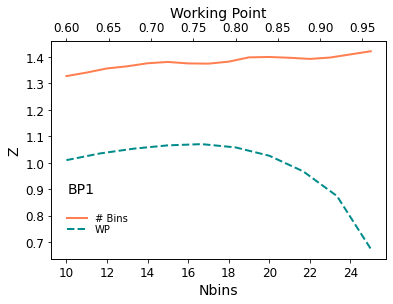

In [56]:
fig,ax = plt.subplots(1,1)

ax2 = ax.twiny()

ax.plot(bins[np.where(Z_bins>0)[0]], Z_bins[np.where(Z_bins>0)[0]], color = 'coral', linewidth =2, label = '# Bins')
ax.set_xlabel('Nbins', fontsize=14)
ax.set_ylabel('Z', fontsize=14)
ax.legend(frameon = False, loc = 'upper left', bbox_to_anchor = (0.02,0.25))

ax2.plot(treshold, Sig_full, color = 'darkcyan', linewidth = 2, ls = '--', label = 'WP')
ax2.set_xlabel('Working Point', fontsize=14)
ax2.legend(frameon = False, loc = 'upper left', bbox_to_anchor = (0.02,0.2))

ax.text(0.05, 0.3, 'BP' + str(bp + 1), fontsize=14, transform = ax.transAxes)

plt.savefig('../graph/Z_WP+Bins_BP' + str(bp + 1) + '_lowLevel.png', bbox_inches='tight')

In [69]:
#################################
# BINNED POISSON LOG-LIKELIHOOD #
#################################

store_Z_bins_XG_16bins = []
store_Z_bins_XG_50bins = []
store_Z_bins_XG_100bins = []


print('B_expected: ', B_expected)
print('S_expected: ', S_expected[bp])
print(r'S/$\sqrt{B}$: ', SsqrtB)

# Les't use an integer number of possible ensembles
N_ensembles_back = len(pred_XG_SM) / B_expected
N_events_back = N_ensembles_back * B_expected

N_ensembles_sig = len(pred_XG_NP) / S_expected[bp]
N_events_sig = N_ensembles_sig * S_expected[bp]



############
# 16 bins #
############

#Let's find out the expected number of B and S events in each bin:

# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(16), range = [[0,1]])
# now divide by the number of possible ensembles
back_prom = hist_back.T.ravel()/N_ensembles_back

# same for signal
hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(16), range = [[0,1]])
sig_prom = hist_sig.T.ravel()/N_ensembles_sig



# If a bins has no expected background events replace that zero for the minimum B_bin=/=0

# find the minimum
back_prom_noceros = []
for i in range(len(back_prom)):
    if back_prom[i]!=0:
        back_prom_noceros.append(back_prom[i])

min_back = min(back_prom_noceros)

# replace the zeros
for i in range(len(back_prom)):
    if back_prom[i]==0:
        back_prom[i] = min_back

# then the signif Z^binned-Asimov:
Z_bins_16bins = ( 2* sum( ( (back_prom + sig_prom) * np.log( 1 + (sig_prom / back_prom) ) ) - sig_prom ) )**0.5
#Z_bins_50bins = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5

store_Z_bins_XG_16bins.append(Z_bins_16bins)

print('Z_bins_16bins : ', Z_bins_16bins)



############
# 50 bins #
############

#Let's find out the expected number of B and S events in each bin:

# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(50), range = [[0,1]])
# now divide by the number of possible ensembles
back_prom = hist_back.T.ravel()/N_ensembles_back

# same for signal
hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(50), range = [[0,1]])
sig_prom = hist_sig.T.ravel()/N_ensembles_sig



# If a bins has no expected background events replace that zero for the minimum B_bin=/=0

# find the minimum
back_prom_noceros = []
for i in range(len(back_prom)):
    if back_prom[i]!=0:
        back_prom_noceros.append(back_prom[i])

min_back = min(back_prom_noceros)

# replace the zeros
for i in range(len(back_prom)):
    if back_prom[i]==0:
        back_prom[i] = min_back

# then the signif Z^binned-Asimov:
Z_bins_50bins = ( 2* sum( ( (back_prom + sig_prom) * np.log( 1 + (sig_prom / back_prom) ) ) - sig_prom ) )**0.5
#Z_bins_50bins = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5

store_Z_bins_XG_50bins.append(Z_bins_50bins)

print('Z_bins_50bins : ', Z_bins_50bins)


############
# 100 bins #
############

#Let's find out the expected number of B and S events in each bin:

# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(100), range = [[0,1]])
# now divide by the number of possible ensembles
back_prom = hist_back.T.ravel()/N_ensembles_back

# same for signal
hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(100), range = [[0,1]])
sig_prom = hist_sig.T.ravel()/N_ensembles_sig



# If a bins has no expected background events replace that zero for the minimum B_bin=/=0

# find the minimum
back_prom_noceros = []
for i in range(len(back_prom)):
    if back_prom[i]!=0:
        back_prom_noceros.append(back_prom[i])

min_back = min(back_prom_noceros)

# replace the zeros
for i in range(len(back_prom)):
    if back_prom[i]==0:
        back_prom[i] = min_back

# then the signif Z^binned-Asimov:
Z_bins_100bins = ( 2* sum( ( (back_prom + sig_prom) * np.log( 1 + (sig_prom / back_prom) ) ) - sig_prom ) )**0.5
#Z_bins_100bins = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5

store_Z_bins_XG_100bins.append(Z_bins_100bins)

print('Z_bins_100bins : ', Z_bins_100bins)


print('\n ----------------------------------- \n')

B_expected:  121397.63394660143
S_expected:  201.9757047257411
S/$\sqrt{B}$:  0.5796876138715118
Z_bins_16bins :  2.2456677632228446
Z_bins_50bins :  3.36700986867008
Z_bins_100bins :  4.235663329116497

 ----------------------------------- 



In [71]:
MIN_EVS = 5 # minimum number of events per bin

#S_expected = S_expected[bp]
B_bins_mean = np.linspace(10, 25, 15).astype('int')

indices_B = np.arange(len(pred_XG_SM))
indices_S = np.arange(len(pred_XG_NP))
###############################
# EQ SIZE CROSS-VAL FOR Nbins #
###############################

print('\n BINNING: eq size bins, with the optimal number of bins: ')


print('minimum number of events per bin: ', MIN_EVS)

print('')



Z_bins_XG_CV_stat = []
Z_bins_XG_CV_stat_zeros = []

Z_bins_XG_CV_stat_std = []
Z_bins_XG_CV_stat_zeros_std = []



print('B_expected: ', B_expected)
print('S_expected: ', S_expected)


# to construct ensembles B and S events are taken from Poisson distributions
mu = S_expected + B_expected


# Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

# around the mean its populated so let's try (proposed range to be checked)
list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
to_check = len(list_events_per_ensembles)

# I want at least one ensemble populated
list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



# Remove from the list the elements without at least 1 ensemble possible
for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] > 1:
        list_events_per_ensembles = list_events_per_ensembles[i:]
        list_nums_ensembles = list_nums_ensembles[i:]
        break


for i in range(len(list_events_per_ensembles)):
    if list_nums_ensembles[i] < 1:
        list_events_per_ensembles = list_events_per_ensembles[:i]
        list_nums_ensembles = list_nums_ensembles[:i]
        break

print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

print('n_ensembles (actual): ', sum(list_nums_ensembles))



# lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

p_berno = S_expected/(S_expected+B_expected)

list_S_per_ensembles = []
list_B_per_ensembles = []

for jj in range(len(list_events_per_ensembles)):
    list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
    list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

######
# NOW I HAVE 4 LISTS:
# list_events_per_ensembles     list with the number of events per ensemble (its a range)
# list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
# list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
# list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
######
    

Z_bins_XG_CV_stat_aux = []
Z_bins_XG_CV_stat_aux_zeros = []

for j_it in range(len(B_bins_mean)):
    
    for bb in range(len(list_nums_ensembles)):

        for kk in range(list_nums_ensembles[bb]):
            
            ran_ind_B = np.random.choice(indices_B, list_B_per_ensembles[bb])
            ran_ind_S = np.random.choice(indices_S, list_S_per_ensembles[bb])
            
            # estimate the variance in each bin as ~ (upB - downB)/2 
            
            pred_XG_SM_shuf = []
            
            pred_XG_NP_shuf = []
            
            for ill in ran_ind_B:
                pred_XG_SM_shuf.append(pred_XG_SM[ill])
                
            for ill in ran_ind_S:
                pred_XG_NP_shuf.append(pred_XG_NP[ill])
                
            

            # Let's find out the expected number of B and S events in each bin:       

            # bin the parameter space of all background events
            hist_back, binedges_back = np.histogramdd([pred_XG_SM_shuf], bins=(B_bins_mean[j_it]), range = [[min(pred_XG_SM_shuf),max(pred_XG_SM_shuf)]])
            bin_edges = binedges_back[0]
            
            back_prom = hist_back.T.ravel()
            
            
            if min(hist_back) >= MIN_EVS:
                #print('ok j_it=', j_it)

                # same for signal
                hist_sig, binedges_sig = np.histogramdd([pred_XG_NP_shuf], bins=[bin_edges])
                sig_prom = hist_sig.T.ravel()

                # then the signif Z^binned-Asimov:
                Z_bins_XG_CV_stat_aux.append( ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5 )

            else:
                print('NO ok j_it=', j_it)

            



            # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

            # find the minimum
            back_prom_noceros = []
            for i in range(len(back_prom)):
                if back_prom[i]!=0:
                    back_prom_noceros.append(back_prom[i])

            min_back = min(back_prom_noceros)

            # replace the zeros
            for i in range(len(back_prom)):
                if back_prom[i]==0:
                    back_prom[i] = min_back
                    
                    
            # same for signal
            hist_sig, binedges_sig = np.histogramdd([pred_XG_NP_shuf], bins=[bin_edges])
            sig_prom = hist_sig.T.ravel()
            
            Z_bins_XG_CV_stat_aux_zeros.append( ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5 )

                    
                    
    # Histogram of q_muhats
    
    print(' CHECK IF YOU HAVE ENOUGH PSEUDO EXPERIMENTS (cause you ask for a minimun number of events per bin): ')
    print('pseudo experiments tested: ', n_ensembles)
    print('pseudo experiments that have at least ', MIN_EVS, ' events per bin: ', len(Z_bins_XG_CV_stat_aux))
    print('\n you need at least... 1000? to describe the distibution')
    print(' if not, increase the number of pseudo experiments' )

    weights = np.ones_like(Z_bins_XG_CV_stat_aux)/float(len(Z_bins_XG_CV_stat_aux))
    nMIX, binsMIX, patchesMIX = plt.hist(Z_bins_XG_CV_stat_aux, 25, weights=weights, histtype='step', color='blue', linewidth=2)
    weights = np.ones_like(Z_bins_XG_CV_stat_aux_zeros)/float(len(Z_bins_XG_CV_stat_aux_zeros))
    nMIX, binsMIX, patchesMIX = plt.hist(Z_bins_XG_CV_stat_aux_zeros, 25, weights=weights, histtype='step', color='green', linewidth=2)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Z",fontsize=16)
    plt.ylabel("Fraction of ensembles",fontsize=16)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.show()
    
    
    # Remove nan if any
    Z_bins_XG_CV_stat_aux = [x for x in Z_bins_XG_CV_stat_aux if x == x]
    for jk in range(len(Z_bins_XG_CV_stat_aux)):
        if Z_bins_XG_CV_stat_aux[jk] < 0:
            Z_bins_XG_CV_stat_aux[jk] = 0

    Z_bins_XG_CV_stat_median = np.median(Z_bins_XG_CV_stat_aux)   
    Z_bins_XG_CV_stat.append(Z_bins_XG_CV_stat_median)
    
    Z_bins_XG_CV_stat_stdX = np.std(Z_bins_XG_CV_stat_aux)   
    Z_bins_XG_CV_stat_std.append(Z_bins_XG_CV_stat_stdX)

    print('# bins: ', B_bins_mean[j_it])
    print('Z median: ', Z_bins_XG_CV_stat_median)
    print('Z std: ', Z_bins_XG_CV_stat_stdX)
    
    
    # Remove nan if any
    Z_bins_XG_CV_stat_aux_zeros = [x for x in Z_bins_XG_CV_stat_aux_zeros if x == x]
    for jk in range(len(Z_bins_XG_CV_stat_aux_zeros)):
        if Z_bins_XG_CV_stat_aux_zeros[jk] < 0:
            Z_bins_XG_CV_stat_aux_zeros[jk] = 0

    Z_bins_XG_CV_stat_zeros_median = np.median(Z_bins_XG_CV_stat_aux_zeros)   
    Z_bins_XG_CV_stat_zeros.append(Z_bins_XG_CV_stat_zeros_median)
    
    Z_bins_XG_CV_stat_zeros_stdX = np.std(Z_bins_XG_CV_stat_aux_zeros)   
    Z_bins_XG_CV_stat_zeros_std.append(Z_bins_XG_CV_stat_zeros_stdX)

    print('# bins: ', B_bins_mean[j_it])
    print('Z median: ', Z_bins_XG_CV_stat_zeros_median)
    print('Z std: ', Z_bins_XG_CV_stat_zeros_stdX)
    print('')

print(' ')


Z_bins_XG_CV_stat_plus = [i+j for i, j in zip(Z_bins_XG_CV_stat, Z_bins_XG_CV_stat_std)]
Z_bins_XG_CV_stat_min = [i-j for i, j in zip(Z_bins_XG_CV_stat, Z_bins_XG_CV_stat_std)]

Z_bins_XG_CV_stat_zeros_plus = [i+j for i, j in zip(Z_bins_XG_CV_stat_zeros, Z_bins_XG_CV_stat_zeros_std)]
Z_bins_XG_CV_stat_zeros_min = [i-j for i, j in zip(Z_bins_XG_CV_stat_zeros, Z_bins_XG_CV_stat_zeros_std)]


 BINNING: eq size bins, with the optimal number of bins: 
minimum number of events per bin:  5

B_expected:  121397.63394660143
S_expected:  [201.97570473 459.24977152  63.74628649 111.01428112 235.04613937
 334.03699928  66.07734672 129.09428136 179.37630638  39.99898458
  73.61985102 102.03944697  22.86159322  41.13873984  57.32096427]


TypeError: only size-1 arrays can be converted to Python scalars

## Binned likelihood (pseudo experiments)

In [98]:
ntrials = 5000 # number of iterations, to search the optimal binning

MIN_EVS = 5 # minimum number of events per bin

n_ensembles = 5000 # number of pseudo experiments to compute Z

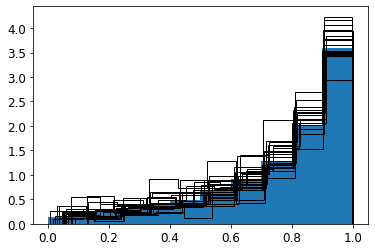

In [275]:
plt.hist(pred_XG_NP,density = True)
for i in range(20):
    pred_NP_aux = np.random.choice(pred_XG_NP, size = np.random.poisson(int(S_expected[bp])), replace = True)
    plt.hist(pred_NP_aux, histtype = 'step', color = 'black',density = True)

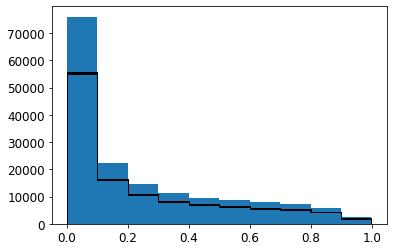

In [276]:
plt.hist(pred_XG_SM)
for i in range(20):
    pred_SM_aux = np.random.choice(pred_XG_SM, size = np.random.poisson(int(B_expected)), replace = True)
    plt.hist(pred_SM_aux, histtype = 'step', color = 'black')

 NUMBER OF BINS


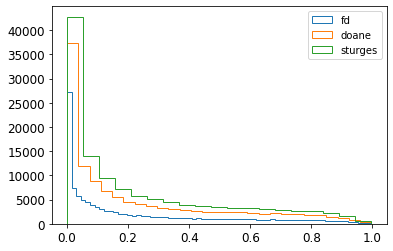

fd 66
doane 27
sturges 19
 


In [277]:
print(' NUMBER OF BINS')

divs_B = int(len(pred_XG_SM) / B_expected)

B_1 = []
B_2 = []
B_3 = []

for it in range(divs_B):
    pred_SM_aux = np.random.choice(pred_XG_SM, size = np.random.poisson(int(B_expected)), replace = True)
    pred_NP_aux = np.random.choice(pred_XG_NP, size = np.random.poisson(int(S_expected[bp])), replace = False)
    
    datB_grid_SM = pred_SM_aux
    datB_grid_NP = pred_NP_aux

    B_hist1 = np.histogram_bin_edges(datB_grid_SM, bins = 'fd')
    B_hist2 = np.histogram_bin_edges(datB_grid_SM, bins = 'doane')
    B_hist3 = np.histogram_bin_edges(datB_grid_SM, bins = 'sturges')
    
    B_1.append(len(B_hist1))
    B_2.append(len(B_hist2))
    B_3.append(len(B_hist3))



B_1_mean = int(np.mean(B_1))
B_2_mean = int(np.mean(B_2))
B_3_mean = int(np.mean(B_3))


B_hist1 = plt.hist(datB_grid_SM, bins = B_1_mean, histtype = 'step', label = 'fd')
B_hist2 = plt.hist(datB_grid_SM, bins = B_2_mean, histtype = 'step', label = 'doane')
B_hist3 = plt.hist(datB_grid_SM, bins = B_3_mean, histtype = 'step', label = 'sturges')
plt.legend()
plt.show()


print('fd', B_1_mean)
print('doane', B_2_mean)
print('sturges', B_3_mean)
print(' ')


# SAVE THE OPTIMAL BIN NUMBER
B_bins_mean = [B_1_mean, B_2_mean, B_3_mean]

In [278]:
mu = np.random.normal(0, np.sqrt(B_expected))

In [279]:
mu

-187.73504754464054

In [280]:
# Tratemos de calcular f(q0|u=0)
#  Es decir la distribucion del estadistico q0 para
#  pseud-experimentos con solo background

B_bins_mean = np.linspace(10, 25, 15).astype('int')#[10,20,30,40,50,60,70,100]

num_pseudo_exp = 1000
q0_bins = []
for j_it in tqdm(range(len(B_bins_mean))):
    
    hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(B_bins_mean[j_it]), range = [[0,1]])
    back_prom = hist_back.T.ravel() / (len(pred_XG_SM) / B_expected)
    q0 = []
    for kk in range(num_pseudo_exp):

        pred_SM_aux = np.random.choice(pred_XG_SM, size = np.random.poisson(int(B_expected)), replace = True)

        # bin the parameter space of all background events
        hist_back_pseudo, _ = np.histogramdd([pred_SM_aux], bins = binedges_back)
        back_prom_pseudo = hist_back_pseudo.T.ravel()
        #%back_prom_pseudo = np.asarray([np.random.poisson(int(i)) for i in hist_back])
        q0_aux = 2 * np.sum( back_prom_pseudo * np.log(back_prom_pseudo / back_prom) + back_prom - back_prom_pseudo )
        if q0_aux >= 0:
            q0.append( q0_aux )
        else: q0.append(0)
    q0_bins.append(q0)

100%|███████████████████████████████████| 15/15 [00:46<00:00,  3.10s/it]


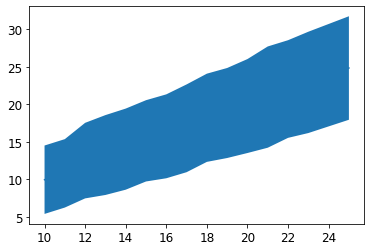

In [281]:
plt.plot(B_bins_mean, np.mean(np.asarray(q0_bins), axis = 1))
plt.fill_between(B_bins_mean, np.mean(np.asarray(q0_bins), axis = 1) + np.std(np.asarray(q0_bins), axis = 1), np.mean(np.asarray(q0_bins), axis = 1) - np.std(np.asarray(q0_bins), axis = 1))

In [282]:
from scipy.stats import chi2

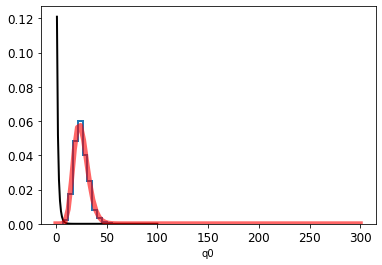

In [283]:
#for i in range(len(B_bins_mean)):
    #plt.hist(q0_bins[i], histtype = 'step', density = True)

i = 14
plt.hist(q0_bins[i], histtype = 'step', density = True, lw = 2)
q0 = np.linspace(1,100, 100)
plt.plot(q0, np.exp(-q0/2) / np.sqrt(q0) / np.sqrt(2 * np.pi) / 2, c = 'black', lw=2)
plt.xlabel('q0')

df = B_bins_mean[i]
x = np.linspace(0,300, 100)
plt.plot(x, chi2.pdf(x, df),
       'r-', lw=5, alpha=0.6, label='chi2 pdf')

#plt.xlim(0,50)

In [346]:
1 - chi2.cdf(50,B_bins_mean[i])

0.0021311519191031802

In [334]:
q0 = np.linspace(1,100, 100)
z = np.sqrt(q0)
z0 = []
for i in q0:
    pval = len(np.where(np.asarray(q0_bins[j_it]) > i)[0]) / len(q0_bins[j_it])
    z0.append( erfinv(1 - pval) )
z0 = np.asarray(z0)

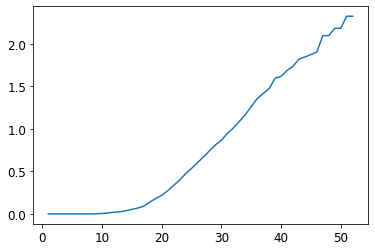

In [335]:
plt.plot(q0,z0)

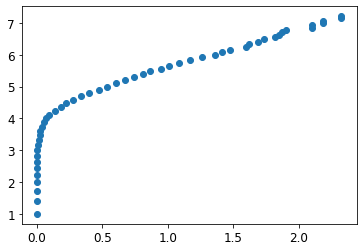

In [336]:
plt.scatter(z0, z)

In [337]:
from scipy.special import erfinv

In [338]:
B_bins_mean = np.linspace(10, 25, 15).astype('int')#[10,20,30,40,50,60,70,100]
Z_bins      = []
Z_bins_full = []
Z_bins_super_exp = []
Z_bins_super_exp_min = []
Z_bins_super_exp_max = []
Z_bins_count = []
q0_full = []
#Z_bins_XG_CV_stat_aux_zeros = []

num_pseudo_exp = 1000
#%num_histos = 15
for j_it in tqdm(range(len(B_bins_mean))):
    
    # Loop for making lot of histograms
    #%Z_bins_histos = []
    #%for bb in range(num_histos): 
    # Loop for making lot of pseudo experiment for a fix histo
    #pred_SM_aux = np.random.choice(pred_XG_SM, size = len(), replace = True)
    hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(B_bins_mean[j_it]), range = [[0,1]])
    bin_edges = binedges_back[0]
    back_prom = hist_back.T.ravel() / (len(pred_XG_SM) / B_expected)

    hist_sig, _ = np.histogramdd([pred_XG_NP], bins=binedges_back)
    sig_prom0 = hist_sig.T.ravel() / (len(pred_XG_NP) / S_expected[bp])
    n_total = sig_prom0 + back_prom
    #%Z_bins_super_exp.append( ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5 ) # Exclusion
    Z_bins_super_exp.append(np.sqrt(2 * np.sum(n_total * np.log(n_total / back_prom) + back_prom - n_total))) # Discovery
    n_total = (sig_prom0 + np.sqrt(sig_prom0)) + (back_prom - np.sqrt(back_prom))
    Z_bins_super_exp_max.append(np.sqrt(2 * np.sum(n_total * np.log(n_total / (back_prom - np.sqrt(back_prom))) + (back_prom - np.sqrt(back_prom)) - n_total))) # Discovery
    n_total = (sig_prom0 - np.sqrt(sig_prom0)) + (back_prom + np.sqrt(back_prom))
    Z_bins_super_exp_min.append(np.sqrt(2 * np.sum(n_total * np.log(n_total / (back_prom + np.sqrt(back_prom))) + (back_prom + np.sqrt(back_prom)) - n_total))) # Discovery
    
    Z_bins_pseudo_exp      = []
    Z_bins_pseudo_exp_full = []
    Z_bins_pseudo_count    = []
    q0_pseudo = []
    for kk in range(num_pseudo_exp):

        pred_SM_aux = np.random.choice(pred_XG_SM, size = np.random.poisson(int(B_expected)), replace = True)
        pred_NP_aux = np.random.choice(pred_XG_NP, size = np.random.poisson(int(S_expected[bp])), replace = False)

        # estimate the variance in each bin as ~ (upB - downB)/2 


        # bin the parameter space of all background events
        hist_back_pseudo, _ = np.histogramdd([pred_SM_aux], bins = binedges_back)
        back_prom_pseudo = hist_back_pseudo.T.ravel()

        if min(hist_back_pseudo) >= MIN_EVS:
            #print('ok j_it={} ; bb={} ; kk={}'.format(j_it, bb, kk))

            # same for signal
            hist_sig_pseudo, _ = np.histogramdd([pred_NP_aux], bins = binedges_back)
            sig_prom_pseudo = hist_sig_pseudo.T.ravel()

            # then the signif Z^binned-Asimov:            
            sig_prom   = sig_prom_pseudo
            back_prom0 = back_prom #+ np.sqrt(back_prom)
            n_total = sig_prom + back_prom
            Z_bins_pseudo_exp.append(np.sqrt(2 * np.sum(n_total * np.log(n_total / back_prom) + back_prom - n_total))) # Discovery
            #Z_bins_pseudo_exp.append( ( 2* sum( ( back_prom0 * np.log( back_prom0 / (sig_prom+back_prom0) ) ) + sig_prom ) )**0.5 ) # Exclusion
            
            # then the signif Z^binned:            
            sig_prom = sig_prom_pseudo + back_prom_pseudo - back_prom# - np.sqrt(back_prom)
            sig_prom[np.where(sig_prom < 0)[0]] = 0            
            n_total = sig_prom + back_prom
            B_hat = 0.5* ( (back_prom-sig_prom) + ((back_prom+sig_prom)**2. - ( (4.*back_prom*sig_prom*(np.sqrt(back_prom)**2))/((np.sqrt(back_prom)**2)+back_prom) ))**0.5 )
            #Z_bins_pseudo_exp_full.append(np.sqrt(2 * np.sum(n_total * np.log(n_total / back_prom) + back_prom - n_total))) # Discovery
            Z_bins_pseudo_exp_full.append( abs( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + B_hat) ) ) - ( (back_prom**2/(np.sqrt(back_prom)**2))*np.log(B_hat/back_prom) ) + ( (B_hat-back_prom)*(1+(back_prom/(np.sqrt(back_prom)**2))) ) + sig_prom ) )**0.5)

            n_total = sig_prom_pseudo + back_prom_pseudo
            q0_aux = 2 * np.sum(n_total * np.log(n_total / back_prom) + back_prom - n_total)
            pval = len(np.where(np.asarray(q0_bins[j_it]) > q0_aux)[0]) / len(q0_bins[j_it])
            if pval == 0: pval = 1e-7
            Z_bins_pseudo_count.append( erfinv(1 - pval) )
            q0_pseudo.append( q0_aux )
        else:
            #Z_bins_pseudo_exp.append(-9999)
            print('No ok j_it={} ; bb={} ; kk={}'.format(j_it, bb, kk))
        #%Z_bins_histos.append(Z_bins_pseudo_exp)
    Z_bins.append(Z_bins_pseudo_exp)
    Z_bins_full.append(Z_bins_pseudo_exp_full)
    Z_bins_count.append(Z_bins_pseudo_count)
    q0_full.append( q0_pseudo )

100%|███████████████████████████████████████████████████████████████████| 15/15 [01:11<00:00,  4.77s/it]


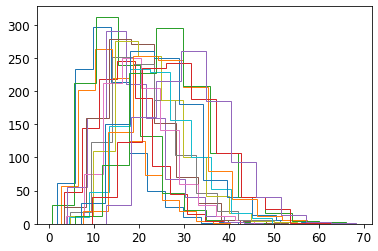

In [339]:
for i in range(len(B_bins_mean)):
    plt.hist(q0_full[i], histtype = 'step')

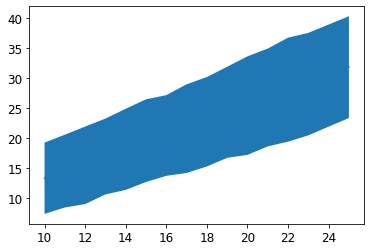

In [340]:
plt.plot(B_bins_mean, np.mean(np.asarray(q0_full), axis = 1))
plt.fill_between(B_bins_mean, np.mean(np.asarray(q0_full), axis = 1) + np.std(np.asarray(q0_full), axis = 1), np.mean(np.asarray(q0_full), axis = 1) - np.std(np.asarray(q0_full), axis = 1))

Text(0, 0.5, 'Z')

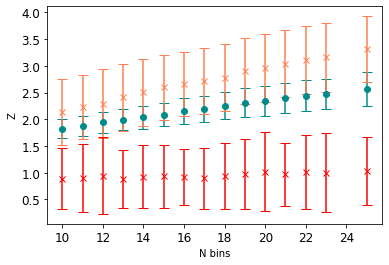

In [341]:
for i in range(len(B_bins_mean)):
    plt.errorbar(B_bins_mean[i], np.mean(Z_bins[i]), np.std(Z_bins[i]), marker = 'o', capsize = 5, color = 'darkcyan')
    plt.errorbar(B_bins_mean[i], np.mean(Z_bins_full[i]), np.std(Z_bins_full[i]), marker = 'x', capsize = 5, color = 'coral')
    plt.errorbar(B_bins_mean[i], np.mean(Z_bins_count[i]), np.std(Z_bins_count[i]), marker = 'x', capsize = 5, color = 'red')
    mean_aux = np.zeros(len(Z_bins[i]))

#plt.errorbar(B_bins_mean, Z_bins_super_exp, yerr=np.asarray((Z_bins_super_exp_min, Z_bins_super_exp_max)), marker = 'v', color = 'black', zorder = 0, capsize = 5)
    
plt.xlabel('N bins')
plt.ylabel('Z')

## unbinned

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf  2968.81548019
  2945.96546373  2918.2076616   2885.19592595  2847.37559515
  2805.41298251  2759.48231558  2706.69455012  2647.29236311
  2582.25009399  2512.57142735  2437.54738808  2357.54230465
  2270.44540148  2177.43955575  2078.43390339  1973.76291292
  1864.39477156  1749.06076813  1626.43954521  1494.57027904
  1353.1305017   1198.66697215  1030.83610171   850.01714574
   652.92751749   435.77366873   199.55501289   -55.14382029
  -327.42631442  -618.42178346  -927.26595301 -1254.35706357
 -1625.46518736 -2111.13167416]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-

Background:  KernelDensity(bandwidth=0.001736984401348869, kernel='epanechnikov')


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf  2017.52501346  2023.70312564  2025.03907336
  2023.01680808  2016.96760999  2006.76609487  1992.94385784
  1976.79390818  1958.70589976  1937.08693228  1911.57415743
  1881.82962998  1845.79697405  1805.21874732  1761.51197717
  1713.04511101  1659.19433036  1600.90022242  1540.36300537
  1480.48065363  1422.18435528  1366.10181165  1306.92867531
  1242.98587963  1171.27579615  1085.42862323   979.75055868
   850.23488362   693.48446925   509.27351274   293.20348307
    40.97534931  -252.39777891  -589.85246793  -979.75140762
 -1437.22922664 -1992.5569726 ]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-

Signal:  KernelDensity(bandwidth=0.001736984401348869, kernel='epanechnikov')


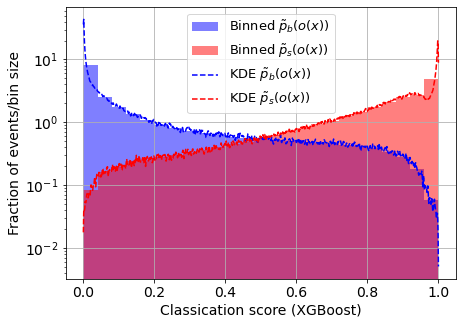

In [95]:
# USE KDE TO ESTIMATE THE CLASSIFIER OUTPUT PDFs



# FIND THE BANDWIDTH  # CHECK IF GOOD RESULTS WITH THIS PARAMETERS
bandwidth = np.logspace(-4.0, 0.05, 50)
num_evs_toKDE = 20000


kde = KernelDensity(kernel='epanechnikov')
grid = GridSearchCV(kde, {'bandwidth': bandwidth})
grid.fit(np.c_[pred_XG_SM[:num_evs_toKDE]])
print('Background: ', grid.best_estimator_)

SM_bandwidth = grid.best_estimator_.bandwidth



kde = KernelDensity(kernel='epanechnikov')
grid = GridSearchCV(kde, {'bandwidth': bandwidth})
grid.fit(np.c_[pred_XG_NP[:num_evs_toKDE]])
print('Signal: ', grid.best_estimator_)

NP_bandwidth = grid.best_estimator_.bandwidth



# with each calculated bandwidth estimate the pdf with KDE to the classifier output (for background and signal)
# notice: epanechnikov kernel
kde_bkg = KernelDensity(kernel="epanechnikov", bandwidth=SM_bandwidth).fit(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ])
kde_sig = KernelDensity(kernel="epanechnikov", bandwidth=NP_bandwidth).fit(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ])



# TO NORMALIZE TO 1, COMPUTE THE AREA

# range
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)


# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )


# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP



# plot to check the estimation 

plt.figure(figsize=(7,5))

plt.hist(pred_XG_SM, 25, range=[0,1], density=True, color='blue',alpha=0.5, linewidth=2, label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.hist(pred_XG_NP, 25, range=[0,1], density=True, color='red',alpha=0.5, linewidth=2, label=r'Binned $\tilde{p}_{s}(o(x))$');

plt.plot(s_vals,dens_bkg,color='blue',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');
plt.plot(s_vals,dens_sig,color='red',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xlabel("Classication score (XGBoost)",fontsize=14)
plt.ylabel("Fraction of events/bin size",fontsize=14)
plt.grid()
plt.legend(loc='upper center',fontsize=13)
plt.show()

In [96]:
#####################################################################
# EVALUATE EVERY POINT IN THE KDE (its faster to de it all at once) #
#####################################################################

# evaluate every BACKGROUND point in the BACKGROUND PDF (obtained with KDE)
KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )

# evaluate every BACKGROUND point in the SIGNAL (yes signal) PDF (obtained with KDE)
KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )


# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP

B_expected:  121697.5512765978
S_expected:  201.9757047257411
n_ensembles (initial):  5000

 If  24380  =  1158    then the proposed range has to be extended
n_ensembles (actual):  3913

 This may take long... 



ValueError: The 'color' keyword argument must have one color per dataset, but 3913 datasets and 1 colors were provided

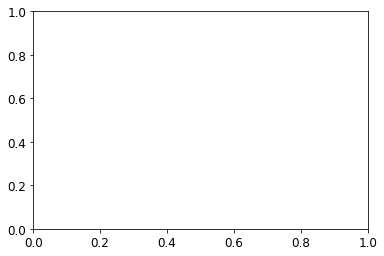

In [102]:
store_muhat_mean_MLL_KDE = []

store_Z_MLL_KDE = []
store_Z_MLL_KDE_mu0 = []

store_Z_MLL_KDE_std = []
store_Z_MLL_KDE_std_mu0 = []


indices = [i for i in range(len(KDE_NP_pred_SM))]


# this loops computes everything for different cases
# for example, for different multiple of S_expected = [100,200,300]
# replace    for iii in range(0,1):     --->    for iii in range(len(S_expected)):
# and replace everywhere    S_expected  --->    S_expected[iii]
for iii in range(0,1):
    
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[bp])
    print('n_ensembles (initial): ', n_ensembles)


    # to construct ensembles B and S events are taken from Poisson distributions
    mu = S_expected[bp] + B_expected


    # Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

    # around the mean its populated so let's try (proposed range to be checked)
    list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
    to_check = len(list_events_per_ensembles)

    # I want at least one ensemble populated
    list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



    # Remove from the list the elements without at least 1 ensemble possible
    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] > 1:
            list_events_per_ensembles = list_events_per_ensembles[i:]
            list_nums_ensembles = list_nums_ensembles[i:]
            break


    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] < 1:
            list_events_per_ensembles = list_events_per_ensembles[:i]
            list_nums_ensembles = list_nums_ensembles[:i]
            break

    print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

    print('n_ensembles (actual): ', sum(list_nums_ensembles))



    # lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

    p_berno = S_expected[bp]/(S_expected[bp]+B_expected)

    list_S_per_ensembles = []
    list_B_per_ensembles = []

    for jj in range(len(list_events_per_ensembles)):
        list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
        list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

    ######
    # NOW I HAVE 4 LISTS:
    # list_events_per_ensembles     list with the number of events per ensemble (its a range)
    # list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
    # list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
    # list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
    ######



    print('\n This may take long... \n')
    
    
    #############################
    # NOW LETS APPLY THE METHOD #
    #############################

    muhat_selected_KDE_list = []
    q_muhat_KDE = []
    q_muhat_KDE_mu0 = []
    
    for bb in range(len(list_nums_ensembles)):

        for kk in range(list_nums_ensembles[bb]):
            
            # KDE
            ran_ind = np.random.choice(indices, list_B_per_ensembles[bb])

            KDE_SM_pred_SM_shuf = []
            KDE_NP_pred_SM_shuf = []

            for i in ran_ind:
                KDE_SM_pred_SM_shuf.append(KDE_SM_pred_SM[i])
                KDE_NP_pred_SM_shuf.append(KDE_NP_pred_SM[i])

            KDE_SM_pred_SM_shuf  = np.array(KDE_SM_pred_SM_shuf)
            KDE_NP_pred_SM_shuf  = np.array(KDE_NP_pred_SM_shuf)





            # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
            prob_x_given_B = np.ndarray.tolist( KDE_SM_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_SM_pred_NP_shuf )

            # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
            prob_x_given_S = np.ndarray.tolist( KDE_NP_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_NP_pred_NP_shuf )



            

            # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
            # WE NEED TO ESTIMATE mu_hat for this particular ensemble
            # we are going to obtain a mu_hat with a grid of values for this particular ensemble

            B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]
            
            sum_muhat_zero = sum ( [(x*1.) / ( (x * 0. * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
            sum_muhat_one = sum ( [(x*1.) / ( (x * 1. * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

            # grid, mu_hat is around 1
            muhat_test = np.arange(0., 1., 0.05).tolist()

            muhat_selected_KDE = 0.0

            if sum_muhat_zero < sum_muhat_one and sum_muhat_zero < 1:

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                    if mu_hat_condition_equal_1 > 1:
                        muhat_selected_KDE = muhat_test[vv]
                        break

            elif sum_muhat_zero > sum_muhat_one and sum_muhat_zero > 1:

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                    if mu_hat_condition_equal_1 < 1:
                        muhat_selected_KDE = muhat_test[vv]
                        break


            muhat_selected_KDE_list.append(muhat_selected_KDE)



            # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
            # and append it (we need the median over lots of ensembles)
            #q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            #q_muhat_mu0.append( 2 * ( (-1.*1. * S_expected) + sum( [np.log( 1 + ( (1.*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            # EXCLUSION:
            q_muhat_KDE.append( 2 * ( ( (1.-muhat_selected_KDE) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected[bp]*x) ) / ( (B_expected*y) + (muhat_selected_KDE*S_expected[bp]*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            q_muhat_KDE_mu0.append( 2 * ( ( (1.-0.) * S_expected[bp] ) - sum( [np.log( ( (B_expected*y) + (S_expected[bp]*x) ) / ( (B_expected*y) + (0.*S_expected[bp]*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )


    # Histogram of q_muhats

    weights = np.ones_like(q_muhat_KDE)/float(len(q_muhat_KDE))
    nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_KDE, 25, histtype='step', color='blue', linewidth=2)
    #%nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_KDE, 25, weights=weights, histtype='step', color='blue', linewidth=2)
    #plt.xlim(0,1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
    plt.ylabel("Fraction of ensembles",fontsize=16)
    plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected[bp]),fontsize=14)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.show()


    # Finally calculate muhat_mean and Z_gaussian
    
    # Remove nan if any
    q_muhat_KDE_mu0 = [x for x in q_muhat_KDE_mu0 if x == x]
    for jk in range(len(q_muhat_KDE_mu0)):
        if q_muhat_KDE_mu0[jk] < 0:
            q_muhat_KDE_mu0[jk] = 0

    q_muhat_KDE_median_mu0 = np.median(q_muhat_KDE_mu0)
    Z_KDE_mu0 = abs(q_muhat_KDE_median_mu0)**0.5
    store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)
    
    q_muhat_KDE_std_mu0 = np.std(q_muhat_KDE_mu0)
    Z_KDE_std_mu0 = q_muhat_KDE_std_mu0/(2.*Z_KDE_mu0)
    store_Z_MLL_KDE_std_mu0.append(Z_KDE_std_mu0)
    

    # Finally calculate muhat_mean and Z_gaussian
    muhat_mean_MLL_KDE = np.mean(muhat_selected_KDE_list)
    store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)

    # Remove nan if any
    q_muhat_KDE = [x for x in q_muhat_KDE if x == x]
    for jk in range(len(q_muhat_KDE)):
        if q_muhat_KDE[jk] < 0:
            q_muhat_KDE[jk] = 0

    q_muhat_KDE_median = np.median(q_muhat_KDE)
    Z_KDE = abs(q_muhat_KDE_median)**0.5
    store_Z_MLL_KDE.append(Z_KDE)
    
    q_muhat_KDE_std = np.std(q_muhat_KDE)
    Z_KDE_std = q_muhat_KDE_std/(2.*Z_KDE)
    store_Z_MLL_KDE_std.append(Z_KDE_std)

    print('muhat mean: ', muhat_mean_MLL_KDE)
    print('median q_muhat_KDE: ', q_muhat_KDE_median)
    print('Z_KDE: ', Z_KDE)
    print('Z_KDE mu=0: ', Z_KDE_mu0)
    print('std Z_KDE: ', Z_KDE_std)
    print('std Z_KDE mu=0: ', Z_KDE_std_mu0)

    print('\n -------------------------------- \n')
    
    
store_Z_MLL_KDE_plus = [i+j for i, j in zip(store_Z_MLL_KDE, store_Z_MLL_KDE_std)]
store_Z_MLL_KDE_min = [i-j for i, j in zip(store_Z_MLL_KDE, store_Z_MLL_KDE_std)]

store_Z_MLL_KDE_mu0_plus = [i+j for i, j in zip(store_Z_MLL_KDE_mu0, store_Z_MLL_KDE_std_mu0)]
store_Z_MLL_KDE_mu0_min = [i-j for i, j in zip(store_Z_MLL_KDE_mu0, store_Z_MLL_KDE_std_mu0)]

In [ ]:
# FIND THE BANDWIDTH  # CHECK IF GOOD RESULTS WITH THIS PARAMETERS
bandwidth = np.logspace(-4.0, 0.05, 50)
num_evs_toKDE = 2000

Z_bins = []

num_pseudo_exp = 10
num_kdes = 3

# Loop for making KDEs
Z_bins_kde = []
    
store_muhat_mean_MLL_KDE = []
store_Z_MLL_KDE = []
store_Z_MLL_KDE_std = []
store_Z_MLL_KDE_mu0 = []
store_Z_MLL_KDE_std_mu0 = []
for bb in tqdm(range(num_kdes)): 
    # Loop for making lot of pseudo experiment for a fix histo
    pred_SM_aux = np.random.choice(pred_XG_SM, size = num_evs_toKDE, replace = True)
    pred_NP_aux = np.random.choice(pred_XG_NP, size = num_evs_toKDE, replace = False)

    kde = KernelDensity(kernel='epanechnikov')
    grid = GridSearchCV(kde, {'bandwidth': bandwidth})
    grid.fit(np.c_[pred_SM_aux])
    print('Background: ', grid.best_estimator_)

    SM_bandwidth = grid.best_estimator_.bandwidth

    kde = KernelDensity(kernel='epanechnikov')
    grid = GridSearchCV(kde, {'bandwidth': bandwidth})
    grid.fit(np.c_[pred_NP_aux])
    print('Signal: ', grid.best_estimator_)

    NP_bandwidth = grid.best_estimator_.bandwidth

    # with each calculated bandwidth estimate the pdf with KDE to the classifier output (for background and signal)
    # notice: epanechnikov kernel
    kde_bkg = KernelDensity(kernel="epanechnikov", bandwidth=SM_bandwidth).fit(np.c_[pred_SM_aux, np.zeros(len(pred_SM_aux)) ])
    kde_sig = KernelDensity(kernel="epanechnikov", bandwidth=NP_bandwidth).fit(np.c_[pred_NP_aux, np.ones(len(pred_NP_aux)) ])

    # TO NORMALIZE TO 1, COMPUTE THE AREA

    # range
    min_val = np.min([np.min(pred_SM_aux),np.min(pred_NP_aux)])
    max_val = np.max([np.max(pred_SM_aux),np.max(pred_NP_aux)])

    s_vals = np.linspace(min_val,max_val,1000)

    # evaluate the densities for each value of s (~bins)
    dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
    dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )

    # Area
    factor_aux_SM = sum(dens_bkg * (s_vals[1]-s_vals[0]))
    factor_aux_NP = sum(dens_sig * (s_vals[1]-s_vals[0]))

    # normalize
    dens_bkg = dens_bkg / factor_aux_SM
    dens_sig = dens_sig / factor_aux_NP

    # plot to check the estimation 

    plt.figure(figsize=(7,5))

    plt.hist(pred_SM_aux, 250, range=[0,1], density=True, color='blue',alpha=0.5, linewidth=2, label=r'Binned $\tilde{p}_{b}(o(x))$');
    plt.hist(pred_NP_aux, 250, range=[0,1], density=True, color='red',alpha=0.5, linewidth=2, label=r'Binned $\tilde{p}_{s}(o(x))$');

    plt.plot(s_vals,dens_bkg,color='blue',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');
    plt.plot(s_vals,dens_sig,color='red',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    #plt.yscale('log')
    plt.xlabel("Classication score (XGBoost)",fontsize=14)
    plt.ylabel("Fraction of events/bin size",fontsize=14)
    plt.grid()
    plt.legend(loc='upper center',fontsize=13)
    plt.show()

    Z_bins_pseudo_exp = []
    muhat_selected_KDE_list = []
    q_muhat_KDE = []
    q_muhat_KDE_mu0 = []
    for kk in range(num_pseudo_exp):       

        pred_SM_aux = np.random.choice(pred_XG_SM, size = num_evs_toKDE, replace = True)
        pred_NP_aux = np.random.choice(pred_XG_NP, size = num_evs_toKDE, replace = False)

        # evaluate every BACKGROUND point in the BACKGROUND PDF (obtained with KDE)
        KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_SM_aux, np.zeros(len(pred_SM_aux)) ]) )

        # evaluate every BACKGROUND point in the SIGNAL (yes signal) PDF (obtained with KDE)
        KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_SM_aux, np.ones(len(pred_SM_aux)) ]) )

        # Normalize

        KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
        KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP

        # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_B = np.ndarray.tolist( KDE_SM_pred_SM ) #+ np.ndarray.tolist( KDE_SM_pred_NP_shuf )

        # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_S = np.ndarray.tolist( KDE_NP_pred_SM ) #+ np.ndarray.tolist( KDE_NP_pred_NP_shuf )

        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
        # WE NEED TO ESTIMATE mu_hat for this particular ensemble
        # we are going to obtain a mu_hat with a grid of values for this particular ensemble

        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        sum_muhat_zero = sum ( [(x*1.) / ( (x * 0. * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_one = sum ( [(x*1.) / ( (x * 1. * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

        # grid, mu_hat is around 1
        muhat_test = np.arange(0., 1., 0.05).tolist()

        muhat_selected_KDE = 0.0

        if sum_muhat_zero < sum_muhat_one and sum_muhat_zero < 1:

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_KDE = muhat_test[vv]
                    break

        elif sum_muhat_zero > sum_muhat_one and sum_muhat_zero > 1:

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_KDE = muhat_test[vv]
                    break


        muhat_selected_KDE_list.append(muhat_selected_KDE)

        # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
        # and append it (we need the median over lots of ensembles)
        #q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
        #q_muhat_mu0.append( 2 * ( (-1.*1. * S_expected) + sum( [np.log( 1 + ( (1.*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
        # EXCLUSION:
        q_muhat_KDE.append( 2 * ( ( (1.-muhat_selected_KDE) * S_expected[bp] ) - sum( [np.log( ( (B_expected*y) + (S_expected[bp]*x) ) / ( (B_expected*y) + (muhat_selected_KDE*S_expected[bp]*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
        q_muhat_KDE_mu0.append( 2 * ( ( (1.-0.) * S_expected[bp] ) - sum( [np.log( ( (B_expected*y) + (S_expected[bp]*x) ) / ( (B_expected*y) + (0.*S_expected[bp]*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )


    # Histogram of q_muhats

    weights = np.ones_like(q_muhat_KDE)/float(len(q_muhat_KDE))
    nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_KDE, 25, weights=weights, histtype='step', color='blue', linewidth=2)
    #plt.xlim(0,1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
    plt.ylabel("Fraction of ensembles",fontsize=16)
    plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected[bp]),fontsize=14)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.show()


    # Finally calculate muhat_mean and Z_gaussian

    # Remove nan if any
    q_muhat_KDE_mu0 = [x for x in q_muhat_KDE_mu0 if x == x]
    for jk in range(len(q_muhat_KDE_mu0)):
        if q_muhat_KDE_mu0[jk] < 0:
            q_muhat_KDE_mu0[jk] = 0

    q_muhat_KDE_median_mu0 = np.median(q_muhat_KDE_mu0)
    Z_KDE_mu0 = abs(q_muhat_KDE_median_mu0)**0.5
    store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)

    q_muhat_KDE_std_mu0 = np.std(q_muhat_KDE_mu0)
    Z_KDE_std_mu0 = q_muhat_KDE_std_mu0/(2.*Z_KDE_mu0)
    store_Z_MLL_KDE_std_mu0.append(Z_KDE_std_mu0)


    # Finally calculate muhat_mean and Z_gaussian
    muhat_mean_MLL_KDE = np.mean(muhat_selected_KDE_list)
    store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)

    # Remove nan if any
    q_muhat_KDE = [x for x in q_muhat_KDE if x == x]
    for jk in range(len(q_muhat_KDE)):
        if q_muhat_KDE[jk] < 0:
            q_muhat_KDE[jk] = 0

    q_muhat_KDE_median = np.median(q_muhat_KDE)
    Z_KDE = abs(q_muhat_KDE_median)**0.5
    store_Z_MLL_KDE.append(Z_KDE)

    q_muhat_KDE_std = np.std(q_muhat_KDE)
    Z_KDE_std = q_muhat_KDE_std/(2.*Z_KDE)
    store_Z_MLL_KDE_std.append(Z_KDE_std)

    print('muhat mean: ', muhat_mean_MLL_KDE)
    print('median q_muhat_KDE: ', q_muhat_KDE_median)
    print('Z_KDE: ', Z_KDE)
    print('Z_KDE mu=0: ', Z_KDE_mu0)
    print('std Z_KDE: ', Z_KDE_std)
    print('std Z_KDE mu=0: ', Z_KDE_std_mu0)

    print('\n -------------------------------- \n')

    
#%store_Z_MLL_KDE_plus = [i+j for i, j in zip(store_Z_MLL_KDE, store_Z_MLL_KDE_std)]
#%store_Z_MLL_KDE_min = [i-j for i, j in zip(store_Z_MLL_KDE, store_Z_MLL_KDE_std)]

#%store_Z_MLL_KDE_mu0_plus = [i+j for i, j in zip(store_Z_MLL_KDE_mu0, store_Z_MLL_KDE_std_mu0)]
#%store_Z_MLL_KDE_mu0_min = [i-j for i, j in zip(store_Z_MLL_KDE_mu0, store_Z_MLL_KDE_std_mu0)]

# Cross-analysis

In [67]:
def train_bp(bp):
    #nobs = len(photon_SM)
    nobs = np.min( (len(photon_SM), len(photon_NP[bp])) )
    df = pd.DataFrame()

    lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
           'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
           'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton',
           'MET $p_T$ [GeV]', 'MET $\phi$',
           '$H_T$ (had) [GeV]', 'num_jets',
           '$H_T$ (main) [GeV]', 'MET sig [GeV]', '$m_{eff}$ [GeV]',
           '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
           '$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
           '$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
           'SM=0 - NP=1']

    SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

    df[lst[0]]= np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][:nobs,0]])
    df[lst[1]]= np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][:nobs,1]])
    df[lst[2]]= np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][:nobs,2]])
    df[lst[3]]= np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][:nobs,3]])

    df[lst[4]]= np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][:nobs,0]])
    df[lst[5]]= np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][:nobs,1]])
    df[lst[6]]= np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][:nobs,2]])

    df[lst[7]]= np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][:nobs,0]])
    df[lst[8]]= np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][:nobs,1]])
    df[lst[9]]= np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][:nobs,2]])
    df[lst[10]]= np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][:nobs,3]])

    df[lst[11]]= np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][:nobs,0]])
    df[lst[12]]= np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][:nobs,2]])

    df[lst[13]]= np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][:nobs,0]])
    df[lst[14]]= np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][:nobs,1]])

    df[lst[15]]= np.concatenate([HT_main_SM[SM_indices], HT_main_NP[bp][:nobs]])
    df[lst[16]]= np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][:nobs]])
    df[lst[17]]= np.concatenate([m_eff_SM[SM_indices], m_eff_NP[bp][:nobs]])

    df[lst[18]]= np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][:nobs]])
    df[lst[19]]= np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][:nobs]])
    df[lst[20]]= np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][:nobs]])

    df[lst[21]]= np.concatenate([phi_MET_photon_SM[SM_indices], phi_MET_photon_NP[bp][:nobs]])
    df[lst[22]]= np.concatenate([phi_MET_jet_SM[SM_indices], phi_MET_jet_NP[bp][:nobs]])
    df[lst[23]]= np.concatenate([phi_MET_lepton_SM[SM_indices], phi_MET_lepton_NP[bp][:nobs]])

    df[lst[24]]= np.concatenate([deltaR_photon_jet_SM[SM_indices], deltaR_photon_jet_NP[bp][:nobs]])
    df[lst[25]]= np.concatenate([deltaR_photon_lepton_SM[SM_indices], deltaR_photon_lepton_NP[bp][:nobs]])
    df[lst[26]]= np.concatenate([deltaR_lepton_jet_SM[SM_indices], deltaR_lepton_jet_NP[bp][:nobs]])


    df['bkg_flag']= np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][:nobs]))) )

    df[lst[27]]= np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][:nobs]))])

    df_array = np.asarray(df)
    # ---------------------------------------------------------------------------------------------------
    
    # Split train-val ----------------------------------------------------------------------------------
    nobs = len(df_array)
    
    train_size = int(0.20 * nobs)
    test_size = int(0.75 * nobs)
    train_size = nobs - train_size - test_size

    np.random.seed(91218)
    random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

    train_indices = random_indices[:train_size]
    test_indices  = random_indices[train_size:(train_size + test_size)]
    val_indices   = random_indices[(train_size + test_size):]
    
    X_train        = df_array[train_indices, :27]
    bkg_flag_train = df_array[train_indices, 27]
    y_mon_train    = df_array[train_indices, -1]
    
    X_val        = df_array[val_indices, :27]
    bkg_flag_val = df_array[val_indices, 27]
    y_mon_val    = df_array[val_indices, -1]
    # ---------------------------------------------------------------------------------------------------

    # Normalize ----------------------------------------------------------------------------------------
    scaler = preprocessing.MinMaxScaler()
    scaler = scaler.fit(X_train)

    X_mon_train = scaler.transform(X_train)
    X_mon_val   = scaler.transform(X_val)
    
    classifier = XGBClassifier(
    n_estimators  = 1500,
    learning_rate = 0.1,
    reg_lambda    = 0.0, reg_alpha = 0.0,
    gamma = 0.0, objective = 'binary:logistic',
    eval_metric = 'logloss', early_stopping_rounds = 50,#early stopping
    max_depth = 5)
    # ---------------------------------------------------------------------------------------------------

    # FIT
    classifier.fit(X_mon_train, y_mon_train, 
                   eval_set = [(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
                   verbose = 0)
    # ---------------------------------------------------------------------------------------------------

    return classifier, scaler

In [68]:
def pred_bp(bp, classifier, scaler):
    #nobs = len(photon_SM)
    nobs = np.min( (len(photon_SM), len(photon_NP[bp])) )
    
    df = pd.DataFrame()
    
    # Put everything in a single array -------------------------------------------------------------
    lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
           'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
           'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton',
           'MET $p_T$ [GeV]', 'MET $\phi$',
           '$H_T$ (had) [GeV]', 'num_jets',
           '$H_T$ (main) [GeV]', 'MET sig [GeV]', '$m_{eff}$ [GeV]',
           '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
           '$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
           '$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
           'SM=0 - NP=1']

    SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

    df[lst[0]]= np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][:nobs,0]])
    df[lst[1]]= np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][:nobs,1]])
    df[lst[2]]= np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][:nobs,2]])
    df[lst[3]]= np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][:nobs,3]])

    df[lst[4]]= np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][:nobs,0]])
    df[lst[5]]= np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][:nobs,1]])
    df[lst[6]]= np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][:nobs,2]])

    df[lst[7]]= np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][:nobs,0]])
    df[lst[8]]= np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][:nobs,1]])
    df[lst[9]]= np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][:nobs,2]])
    df[lst[10]]= np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][:nobs,3]])

    df[lst[11]]= np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][:nobs,0]])
    df[lst[12]]= np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][:nobs,2]])

    df[lst[13]]= np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][:nobs,0]])
    df[lst[14]]= np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][:nobs,1]])

    df[lst[15]]= np.concatenate([HT_main_SM[SM_indices], HT_main_NP[bp][:nobs]])
    df[lst[16]]= np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][:nobs]])
    df[lst[17]]= np.concatenate([m_eff_SM[SM_indices], m_eff_NP[bp][:nobs]])

    df[lst[18]]= np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][:nobs]])
    df[lst[19]]= np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][:nobs]])
    df[lst[20]]= np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][:nobs]])

    df[lst[21]]= np.concatenate([phi_MET_photon_SM[SM_indices], phi_MET_photon_NP[bp][:nobs]])
    df[lst[22]]= np.concatenate([phi_MET_jet_SM[SM_indices], phi_MET_jet_NP[bp][:nobs]])
    df[lst[23]]= np.concatenate([phi_MET_lepton_SM[SM_indices], phi_MET_lepton_NP[bp][:nobs]])

    df[lst[24]]= np.concatenate([deltaR_photon_jet_SM[SM_indices], deltaR_photon_jet_NP[bp][:nobs]])
    df[lst[25]]= np.concatenate([deltaR_photon_lepton_SM[SM_indices], deltaR_photon_lepton_NP[bp][:nobs]])
    df[lst[26]]= np.concatenate([deltaR_lepton_jet_SM[SM_indices], deltaR_lepton_jet_NP[bp][:nobs]])


    df['bkg_flag']= np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][:nobs]))) )

    df[lst[27]]= np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][:nobs]))])

    df_array = np.asarray(df)

    nobs = len(df_array)
    # ---------------------------------------------------------------------------------------------------

    # Split test --------------------------------------------------------------------------------------
    train_size = int(0.20 * nobs)
    test_size  = int(0.75 * nobs)
    val_size   = nobs - test_size - train_size

    np.random.seed(91218)
    random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

    train_indices = random_indices[:train_size]
    test_indices  = random_indices[train_size:(train_size + test_size)]
    val_indices   = random_indices[(train_size + test_size):]
    
    X_test        = df_array[test_indices, :27]
    bkg_flag_test = df_array[test_indices, 27]
    y_mon_test    = df_array[test_indices, -1]
    # ---------------------------------------------------------------------------------------------------

    # Normalize ----------------------------
    X_mon_test  = scaler.transform(X_test)
    # ---------------------------------------------------------------------------------------------------
    
    # PREDICTIONS
    y_pred_xg = classifier.predict_proba(X_mon_test).T[1]
    # ---------------------------------------------------------------------------------------------------
    
    
    return y_pred_xg, y_mon_test, bkg_flag_test

In [69]:
def roc_curve(y_pred_xg, y_mon_test, bkg_flag_test):
    ind_signal  = np.where(bkg_flag_test == 0)[0]
    ind_wgamma  = np.where(bkg_flag_test == 1)[0] # W gamma
    ind_wjets   = np.where(bkg_flag_test == 2)[0] # W jets
    ind_ttgamma = np.where(bkg_flag_test == 3)[0] # tt gamma
    # Let's estimate the ROC Curve
    nvals = 50
    tpr_total   = np.zeros(nvals) 
    fpr_total   = np.zeros(nvals) 
    tpr_ttgamma = np.zeros(nvals) 
    fpr_ttgamma = np.zeros(nvals) 
    tpr_wgamma  = np.zeros(nvals) 
    fpr_wgamma  = np.zeros(nvals) 
    tpr_wjets   = np.zeros(nvals) 
    fpr_wjets   = np.zeros(nvals) 

    for ith, th in enumerate(np.linspace(0,1, nvals)):
        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_total[ith] = len(tp) / (len(tp) + len(fn))
        fpr_total[ith] = len(fp) / (len(fp) + len(tn))
        auc_total = auc(fpr_total, tpr_total)

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 1) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 1) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_wgamma[ith] = len(tp) / (len(tp) + len(fn))
        fpr_wgamma[ith] = len(fp) / (len(fp) + len(tn))
        auc_wgamma = auc(fpr_wgamma, tpr_wgamma)

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 2) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 2) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_wjets[ith] = len(tp) / (len(tp) + len(fn))
        fpr_wjets[ith] = len(fp) / (len(fp) + len(tn))
        auc_wjets = auc(fpr_wjets, tpr_wjets)

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 3) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 3) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_ttgamma[ith] = len(tp) / (len(tp) + len(fn))
        fpr_ttgamma[ith] = len(fp) / (len(fp) + len(tn))
        auc_ttgamma = auc(fpr_ttgamma, tpr_ttgamma)

    return tpr_total, fpr_total, auc_total, tpr_wgamma, fpr_wgamma, auc_wgamma,tpr_wjets, fpr_wjets, auc_wjets, tpr_ttgamma, fpr_ttgamma, auc_ttgamma

In [70]:
def bin_lik_bp(y_pred_xg, bkg_flag_test, S_expected):
    pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
    pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]
    
    #B_expected = (1674.4584461333332 + 59997.68515734306 + 64899.72420521739) 
    # Les't use an integer number of possible ensembles
    N_ensembles_back = len(pred_XG_SM) / B_expected
    N_events_back = N_ensembles_back * B_expected

    N_ensembles_sig = len(pred_XG_NP) / S_expected
    N_events_sig = N_ensembles_sig * S_expected

    bins = np.linspace(10, 25, 15).astype('int')
    Z_bins = np.zeros(len(bins))

    for ib, nbin in enumerate(bins):
        # bin the parameter space of all background events
        hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(nbin), range = [[0,1]])
        # now divide by the number of possible ensembles
        back_prom = hist_back.T.ravel()/N_ensembles_back

        # same for signal
        hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=binedges_back, range = [[0,1]])
        sig_prom = hist_sig.T.ravel()/N_ensembles_sig        

        if np.min(back_prom) > 5:
            # then the signif Z^binned-Asimov for DISCOVERY:
            Z_bins[ib] = ( 2* sum( ( (back_prom + sig_prom) * np.log( 1 + (sig_prom / back_prom) ) ) - sig_prom ) )**0.5
    return bins, Z_bins

0
1
2
3
4


FileNotFoundError: [Errno 2] No such file or directory: '../graph/cross_analysis_2-5-8-11-14_20/75.png'

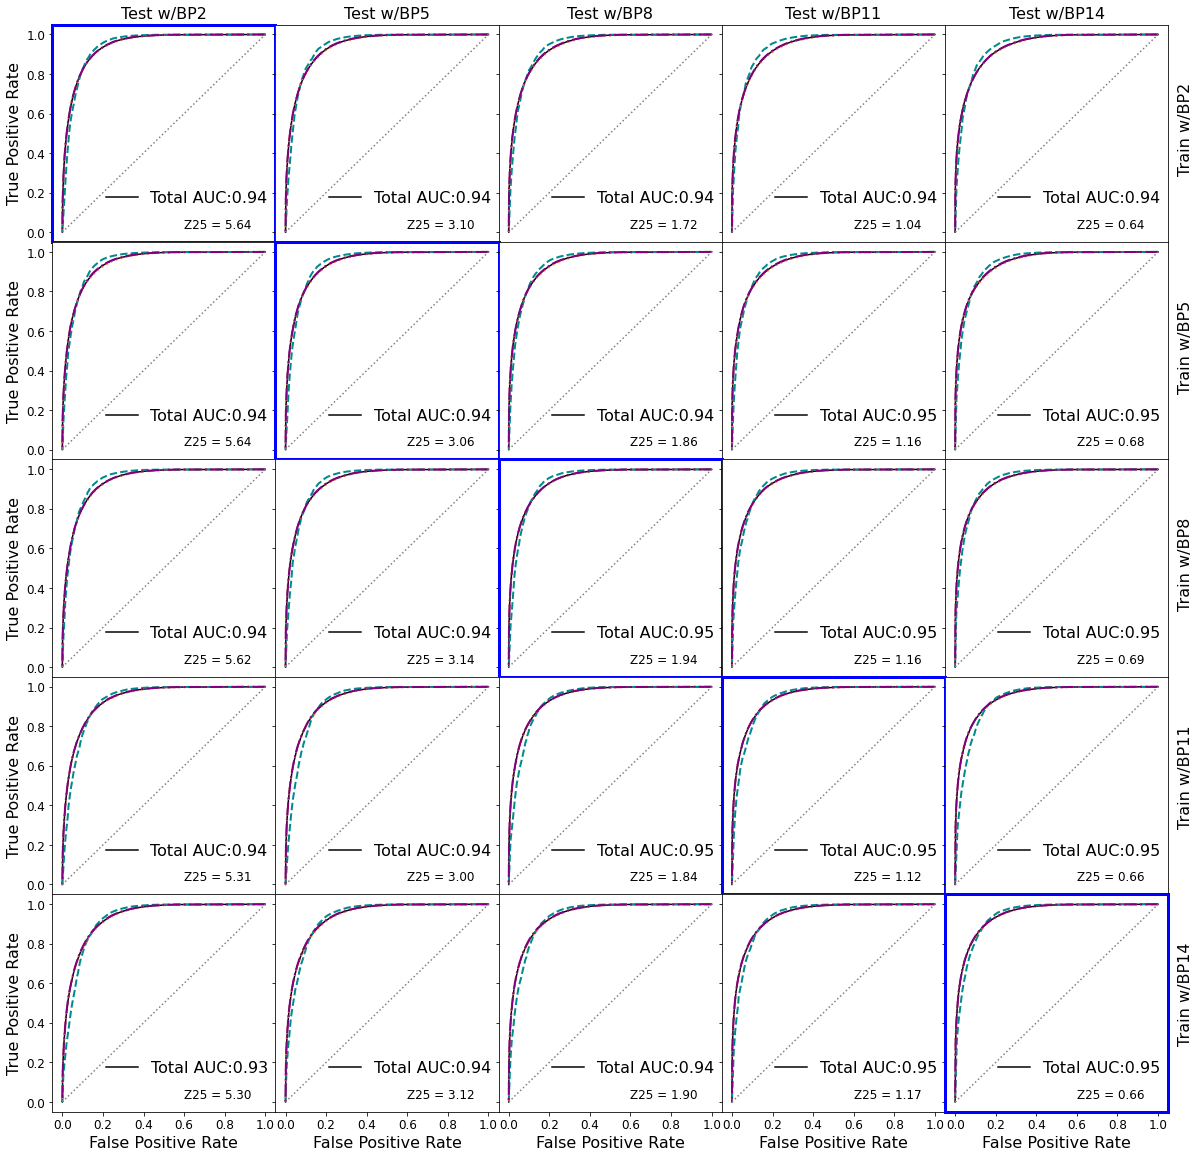

In [71]:
bps = [1,4,7,10,13]
fig,ax = plt.subplots(len(bps),len(bps), figsize = (20,20), sharex = True, sharey = True)

plt.subplots_adjust(wspace = 0, hspace = 0)

for i, bptrain in enumerate(bps):
    print(i)
    for j, bptest in enumerate(bps):
        classifier, scaler = train_bp(bptrain)
        y_pred_xg, y_mon_test, bkg_flag_test = pred_bp(bptest, classifier, scaler)
        tpr_total, fpr_total, auc_total, tpr_wgamma, fpr_wgamma, auc_wgamma, tpr_wjets, fpr_wjets, auc_wjets, tpr_ttgamma, fpr_ttgamma, auc_ttgamma = roc_curve(y_pred_xg, y_mon_test, bkg_flag_test)
        bins, Z_bins = bin_lik_bp(y_pred_xg, bkg_flag_test, S_expected[bptest])
                
        ax[i,j].plot(fpr_total, tpr_total, c = 'black', label = 'Total AUC:{:.2f}'.format(auc_total))
        ax[i,j].plot(fpr_ttgamma, tpr_ttgamma, c = 'darkcyan', linestyle = '--', lw = 2)
        ax[i,j].plot(fpr_wgamma, tpr_wgamma, c = 'coral', linestyle = ':', lw = 2)
        ax[i,j].plot(fpr_wjets, tpr_wjets, c = 'purple', linestyle = '-.', lw = 2)
        ax[i,j].legend(frameon=False, fontsize=16, loc = 'lower right', bbox_to_anchor = (1.03,0.1))
        ax[i,j].text(0.6,0.02, 'Z{} = {:.2f}'.format(bins[np.argmax(Z_bins)], np.max(Z_bins)), fontsize = 12)
        ax[i,j].plot([0,1],[0,1],ls=":",color="grey")
#ax[i,j].title(r"BP" + str(bp + 1),fontsize=16)
        if i == 0: ax[i,j].set_title("Test w/BP" + str(bptest + 1), fontsize=16)
        if j == 0: ax[i,j].set_ylabel("True Positive Rate", fontsize=16)
        if j == (len(bps) - 1): ax[i,j].text(1.1,0.3,"Train w/BP" + str(bptrain + 1),rotation = 90,fontsize=16)
        if j == i: 
            ax[i,j].spines['top'].set_color('blue')  # Top spine
            ax[i,j].spines['bottom'].set_color('blue')  # Bottom spine
            ax[i,j].spines['left'].set_color('blue')  # Left spine
            ax[i,j].spines['right'].set_color('blue')  # Right spine
            ax[i,j].spines['top'].set_linewidth(3)
            ax[i,j].spines['bottom'].set_linewidth(3)
            ax[i,j].spines['left'].set_linewidth(3)
            ax[i,j].spines['right'].set_linewidth(3)        
        if i == (len(bps) - 1): ax[i,j].set_xlabel("False Positive Rate",fontsize=16)

plt.savefig('../graph/cross_analysis_2-5-8-11-14.png')